<a href="https://colab.research.google.com/github/broadinstitute/BEClust3D/blob/main/SingleScreen_MultipleGene_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary Steps

In [1]:
# @title Install Dependencies
# @markdown Run this cell to install the necessary packages for this notebook.
!pip install wget
!pip install DSSPparser
!pip install biopandas

import sys
import os
import math
import wget
import shutil
import statistics
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

import scipy.stats as stats

from google.colab import drive
from google.colab import files
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b417cfeb01476fbd86c80ba58be64fb8d07ba8a20a70693e838105f52095a160
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 1.6 MB/s eta 0:00:00


In [2]:
# @title Mount Drive and Set Directory
# @markdown Enter the path to your current work directory. This directory should
# @markdown contain this Colab notebook and a folder with the screen data titled
# @markdown **rawdata**.\
# @markdown ex: *'Broad Work/BE Workflow'*
drive.mount('/content/drive', force_remount=True)

folder_path = 'BE Project' # @param {type:"string"}
sys.path.append('/content/drive/My Drive/{}'.format(folder_path))
workdir = '/content/drive/My Drive/{}'.format(folder_path)
print("The selected work directory is '{}'".format(workdir))

Mounted at /content/drive
The selected work directory is '/content/drive/My Drive/BE Project'


In [3]:
# @title Output Folders
# @markdown Run this cell to create the **screendata**, **plots**, and
# @markdown **qc_validation** folders inside the work directory.
if os.path.isdir('{}/screendata'.format(workdir)):
    print('{}/screendata already exists'.format(workdir))
else:
    os.makedirs('{}/screendata'.format(workdir))
    print('{}/screendata created!'.format(workdir))

if  os.path.isdir('{}/plots'.format(workdir)):
    print('{}/plots already exists'.format(workdir))
else:
    os.makedirs('{}/plots'.format(workdir))
    print('{}/plots created!'.format(workdir))

if  os.path.isdir('{}/qc_validation'.format(workdir)):
    print('{}/qc_validation already exists'.format(workdir))
else:
    os.makedirs('{}/qc_validation'.format(workdir))
    print('{}/qc_validation created!'.format(workdir))

/content/drive/My Drive/BE Project/screendata created!
/content/drive/My Drive/BE Project/plots created!
/content/drive/My Drive/BE Project/qc_validation created!


# QC Steps

In [4]:
from operator import is_
# @title Screen data ID
# @markdown Enter the name of the screen. The format of the title should adhere
# @markdown to the following guide:
# @markdown *Species_CellModel_BaseEditType_Comparison_InputCondition*

# @markdown Both .tsv and .txt files are accepted.
input_screen = 'Human_InVitro_SW480_Apobec_D14_Input' # @param {type:"string"}
is_file = True
rawinput_tsv = workdir + "/rawdata/" + input_screen + ".tsv"
rawinput_txt = workdir + "/rawdata/" + input_screen + ".txt"
if os.path.isfile(rawinput_tsv): rawinput = rawinput_tsv
elif os.path.isfile(rawinput_txt): rawinput = rawinput_txt
else:
    df_rawinput = pd.DataFrame()
    is_file = False
    print("File not found!")
if is_file:
    df_rawinput = pd.read_csv(rawinput, sep='\t')
    print(df_rawinput.shape)
df_rawinput.head(7)

(5539, 6)


,Gene_Name,gRNA_Sequence,Amino_Acid_Edits,Mutation_Type,Mutation_Category,Score
0,SETDB2,AAAAAATGCAAAATGTAGTT,NaN,NaN,No Mutation,0.494023
1,PPHLN1,AAAAACCAAAGAGATTGAAC,T298I,Missense,Missense,-0.019005
2,MPHOSPH8,AAAAAGAAAAAAGCAAAGGC,NaN,NaN,No Mutation,0.447030
3,MORC2,AAAAAGATTACCCTGACACC,NaN,NaN,No Mutation,0.774897
4,ATF7IP,AAAAAGTTACCTGTATTCAC,NaN,NaN,No Mutation,1.363416
5,MORC2,AAAACAAAATTCAGTTCCTT,V369I,Missense,Missense,0.111637
6,EHMT1,AAAACCCTTCCTGGAGGGGC,"T154I, L155F","Missense, Missense",Missense,2.322044


In [5]:
# @title Column Name Check
# @markdown Run this cell to perform a name check on the column titles in the given data.\
# @markdown The table must adhere to the following column order and naming requirements:
# @markdown 1. Gene_Name
# @markdown 2. gRNA_Sequence
# @markdown 3. Nucleotide_Edits (optional)
# @markdown 4. Amino_Acid_Edits
# @markdown 5. Mutation_Type
# @markdown 6. Mutation_Category
# @markdown 7. Score

misnamed_cols = []
correct_col_names = ["Gene_Name", "gRNA_Sequence", "Nucleotide_Edits", "Amino_Acid_Edits",\
                     "Mutation_Type", "Mutation_Category", "Score"]

if len(df_rawinput.columns) == 7:
    for idx in range(len(df_rawinput.columns)):
        if df_rawinput.columns[idx] != correct_col_names[idx]:
            misnamed_cols.append(df_rawinput.columns[idx])
elif len(df_rawinput.columns) == 6:
    temp_columns = list(df_rawinput.columns)
    temp_columns.insert(2, "Nucleotide_Edits")
    for idx in range(len(temp_columns)):
        if temp_columns[idx] != correct_col_names[idx]:
            misnamed_cols.append(df_rawinput.columns[idx])
else:
    print("Incorrect number of columns present in table!")


if misnamed_cols:
    print("The following column names are incorrect: {}".format(misnamed_cols))
    print("Please fix column headers in accordance with the guidelines outlined in this cell before proceeding!")
else:
    print("All column names are correct!")

All column names are correct!


Genes present in screen: ['SETDB2' 'PPHLN1' 'MPHOSPH8' 'MORC2' 'ATF7IP' 'EHMT1' 'TASOR' 'SUV39H2'
 'SETDB1' 'EHMT2' 'ATF7IP2' 'PTPN2' 'TRIM28' 'SUV39H1']

Mutation types present in screen: ['No Mutation' 'Missense' 'Intronic' 'Nonsense' 'UTR' 'Silent'
 'Splice Site' 'Flank']

Total count of Missense rows: 2482
Total count of Silent rows: 855
Total count of Nonsense rows: 257
Total count of No Mutation rows: 1349
Total count of Splice rows: 132


<Figure size 640x480 with 0 Axes>

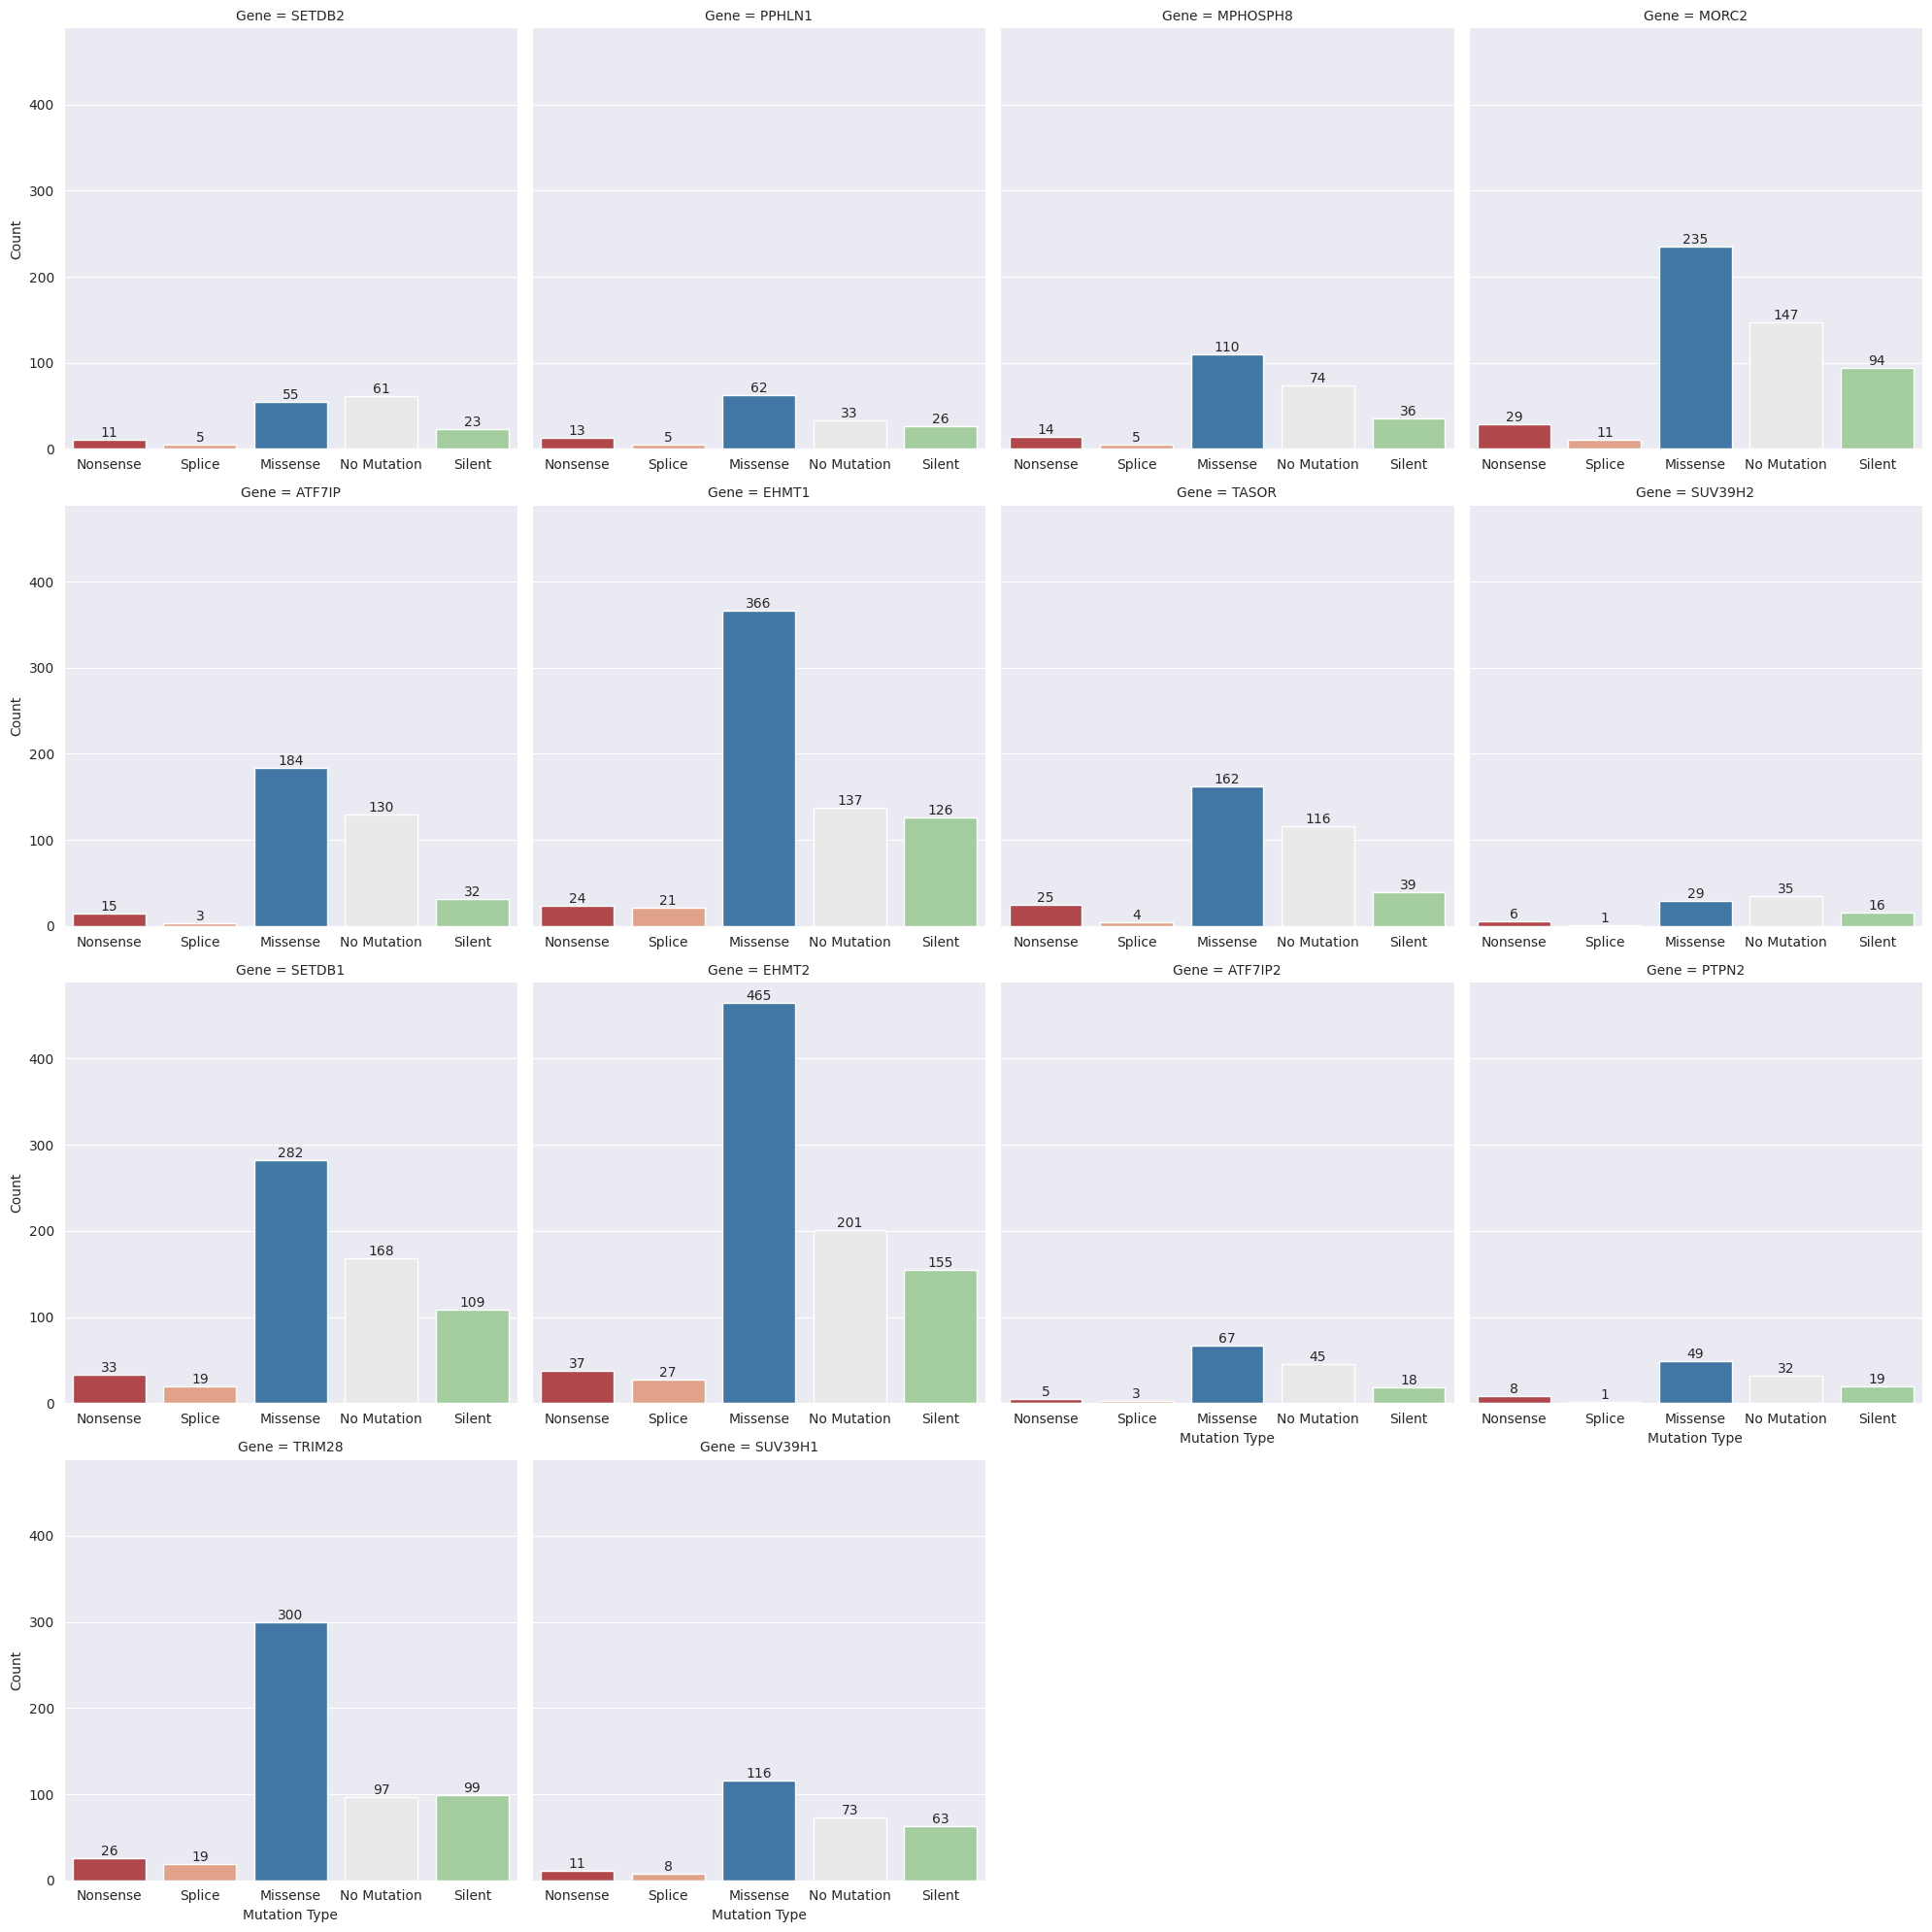

In [6]:
# @title Summary Statistics
# @markdown Run this cell to generate summary statistics about the screen data:
# @markdown - list of all genes
# @markdown - list of unique mutation types
# @markdown - bar plots displaying the per-gene mutation counts of the following types:
# @markdown  - nonsense
# @markdown  - splice
# @markdown  - missense
# @markdown  - no mutation
# @markdown  - silent \
# @markdown
# @markdown
# @markdown The barplots will be saved into the **plots** folder.

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

unique_genes = df_rawinput.Gene_Name.unique()
print("Genes present in screen: {}".format(unique_genes))
print()

print("Mutation types present in screen: {}".format(df_rawinput.Mutation_Category.unique()))
print()

# missense
df_InputGene_missense = df_rawinput.loc[df_rawinput['Mutation_Category'] == 'Missense', ]
df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)
print("Total count of Missense rows: " + str(len(df_InputGene_missense)))

# silent
df_InputGene_silent = df_rawinput.loc[df_rawinput['Mutation_Category'] == 'Silent', ]
df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)
print("Total count of Silent rows: " + str(len(df_InputGene_silent)))

# nonsense
df_InputGene_nonsense = df_rawinput.loc[df_rawinput['Mutation_Category'] == 'Nonsense', ]
df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)
print("Total count of Nonsense rows: " + str(len(df_InputGene_nonsense)))

# no mutation
df_InputGene_nomutation = df_rawinput.loc[df_rawinput['Mutation_Category'] == 'No Mutation', ]
df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)
print("Total count of No Mutation rows: " + str(len(df_InputGene_nomutation)))

# splice site
df_InputGene_splice = df_rawinput.loc[df_rawinput['Mutation_Category'] == 'Splice Site', ]
df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)
print("Total count of Splice rows: " + str(len(df_InputGene_splice)))

# Compile gene-specific mutation counts, by mutation type
df_mutation_counts = pd.DataFrame(columns = ['Gene', 'Nonsense', 'Splice',\
                                             'Missense', 'No Mutation', 'Silent'],\
                                   index=[0])
for idx, current_gene in enumerate(unique_genes):
    df_current_gene = df_rawinput.loc[df_rawinput['Gene_Name'] == current_gene, ]
    nonsense = len(df_current_gene.loc[df_current_gene['Mutation_Category'] == 'Nonsense', ])
    no_mutation = len(df_current_gene.loc[df_current_gene['Mutation_Category'] == 'No Mutation', ])
    silent = len(df_current_gene.loc[df_current_gene['Mutation_Category'] == 'Silent', ])
    splice = len(df_current_gene.loc[df_current_gene['Mutation_Category'] == 'Splice Site', ])
    missense = len(df_current_gene.loc[df_current_gene['Mutation_Category'] == 'Missense', ])
    df_mutation_counts.loc[idx] = [current_gene, nonsense, splice, missense, no_mutation, silent]

# plotting
sns.set_style("darkgrid")
plt.tight_layout()
plot_dim = math.ceil(math.sqrt(len(unique_genes)))
pal = ['#c13639', '#f09c7b', '#2f79b5', '#e9e9e9', '#9cd597']
ax = sns.catplot(data=df_mutation_counts.melt("Gene", var_name="Mutation Type", value_name="Count"),\
            x="Mutation Type", y="Count", kind="bar", col_wrap=plot_dim, hue="Mutation Type",\
            col="Gene", palette=pal, sharex = False)
for ax in ax.axes.flat:
    for idx in range(len(ax.containers)):
        ax.bar_label(ax.containers[idx])

# save figure
plt.savefig(workdir + "/plots/" + input_screen + "_muttype_count.pdf", dpi=300)
if download == 'Yes':
    files.download(workdir + "/plots/" + input_screen + "_muttype_count.pdf")

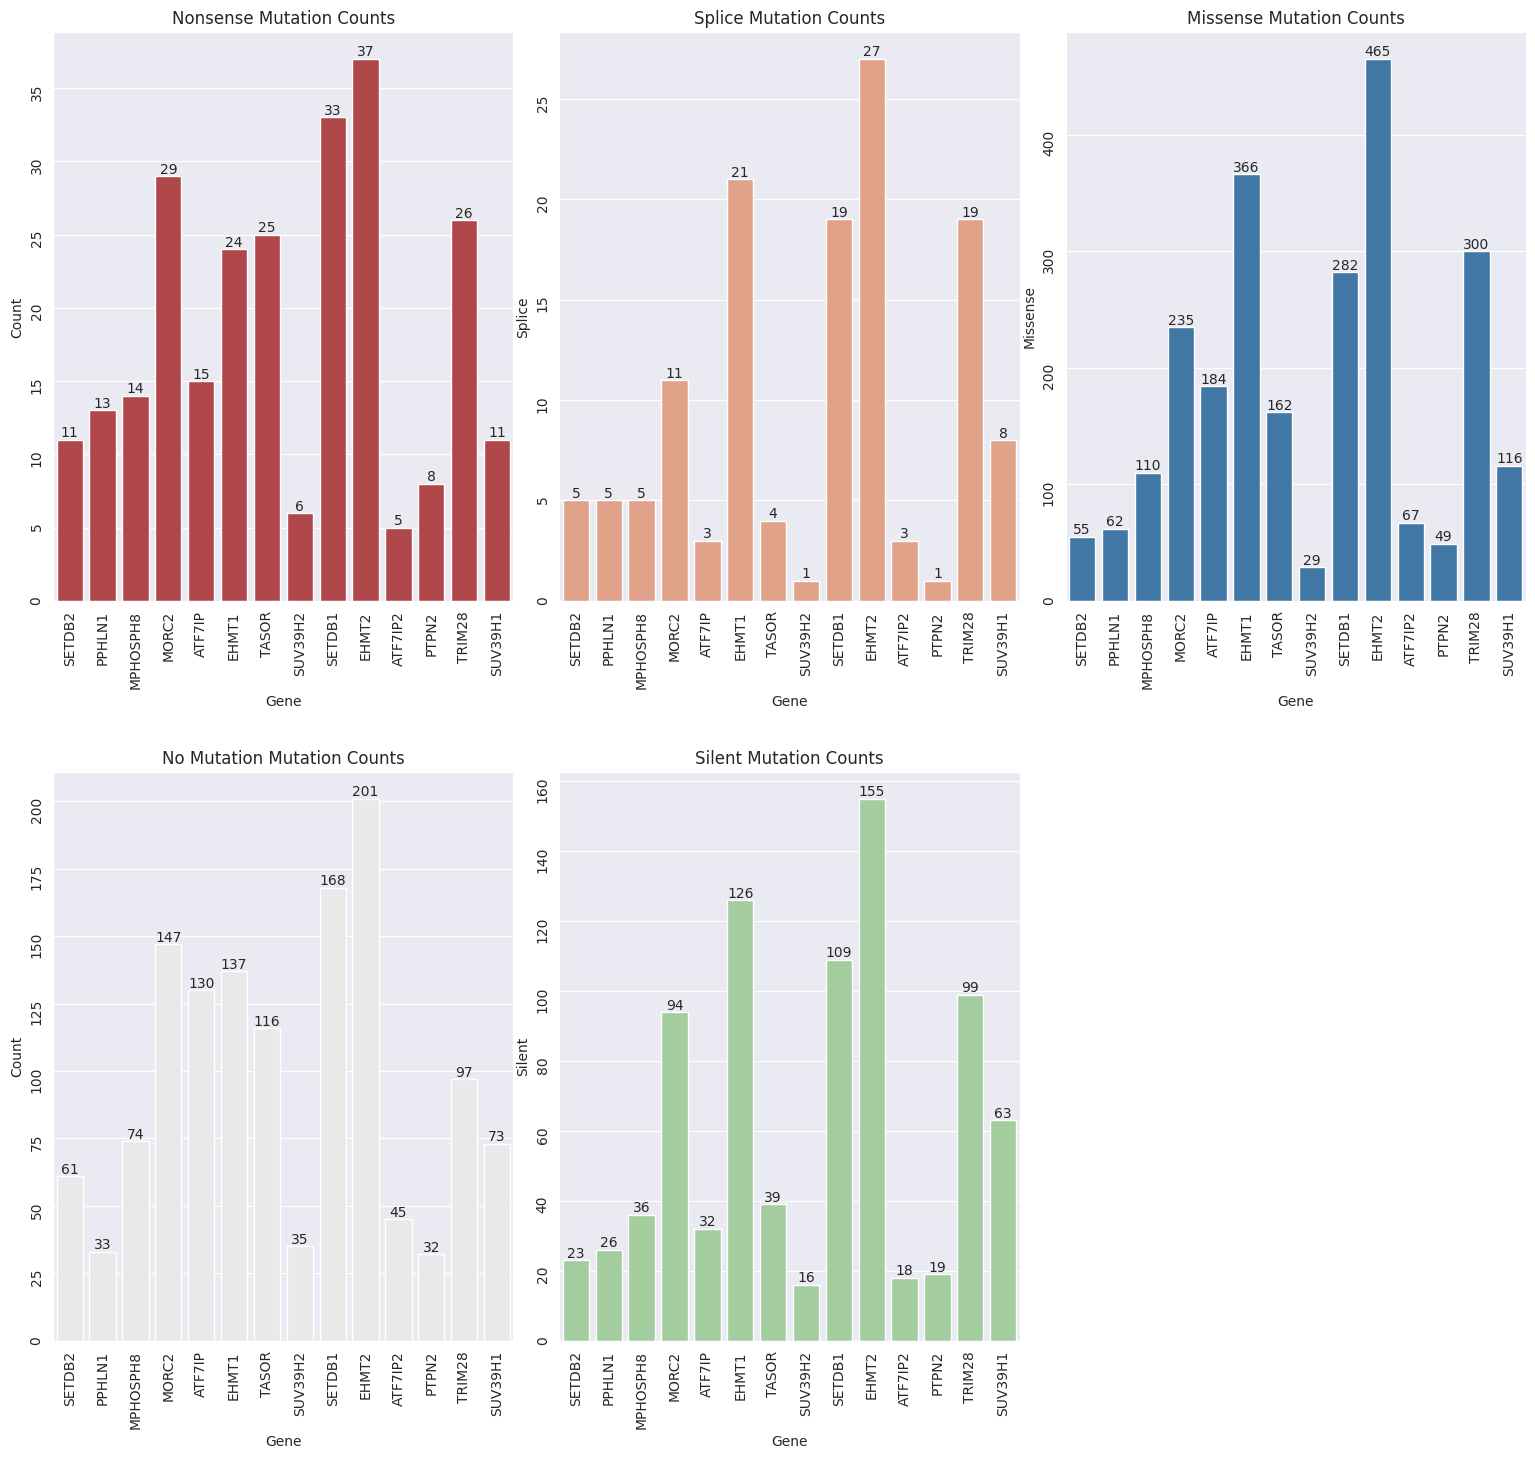

In [7]:
# @title Mutation Counts
# @markdown Run this cell to create barplots displaying the global counts of each
# @markdown mutation type, broken down by gene. The figure will be saved into the
# @markdown **plots** folder.

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(19,17), gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

# nonsense barplot
nonsense_plot = sns.barplot(ax=axes[0, 0], data=df_mutation_counts, x="Gene", \
                            y="Nonsense", color='#c13639')
for ax in nonsense_plot.containers: nonsense_plot.bar_label(ax)
nonsense_plot.set_ylabel("Count")
nonsense_plot.set_title("Nonsense Mutation Counts")
nonsense_plot.tick_params(labelrotation=90)

# splice barplot
splice_plot = sns.barplot(ax=axes[0, 1], data=df_mutation_counts, x="Gene", \
                          y="Splice", color='#f09c7b')
for ax in splice_plot.containers: splice_plot.bar_label(ax)
splice_plot.set_title("Splice Mutation Counts")
splice_plot.tick_params(labelrotation=90)

# missense barplot
missense_plot = sns.barplot(ax=axes[0, 2], data=df_mutation_counts, x="Gene", \
                            y="Missense", color='#2f79b5')
for ax in missense_plot.containers: missense_plot.bar_label(ax)
missense_plot.set_title("Missense Mutation Counts")
missense_plot.tick_params(labelrotation=90)

# no mutation barplot
nomutation_plot = sns.barplot(ax=axes[1, 0], data=df_mutation_counts, x="Gene", \
                              y="No Mutation", color='#e9e9e9')
for ax in nomutation_plot.containers: nomutation_plot.bar_label(ax)
nomutation_plot.set_ylabel("Count")
nomutation_plot.set_title("No Mutation Mutation Counts")
nomutation_plot.tick_params(labelrotation=90)

# silent barplot
silent_plot = sns.barplot(ax=axes[1, 1], data=df_mutation_counts, x="Gene", \
                          y="Silent", color='#9cd597')
for ax in silent_plot.containers: silent_plot.bar_label(ax)
silent_plot.set_title("Silent Mutation Counts")
silent_plot.tick_params(labelrotation=90)

# remove empty plot
fig.delaxes(axes.flatten()[5])

# save figure
plt.savefig(workdir + "/plots/" + input_screen + "_per_muttype_count.pdf", dpi=300)
if download == 'Yes':
    files.download(workdir + "/plots/" + input_screen + "_per_muttype_count.pdf")

In [11]:
# @title Create TSV Files
# @markdown Run this cell to clean up the screen data and create each genes'
# @markdown mutation-wise TSV files. The TSV files can be found in the
# @markdown **screendata** folder.

for current_gene in unique_genes:
    df_InputGene = df_rawinput.loc[df_rawinput['Gene_Name'] == current_gene, ]

    # no mutation
    df_InputGene_nomutation = df_InputGene.loc[df_InputGene['Mutation_Category'] == 'No Mutation', ]
    df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)
    df_nomutation_new = pd.DataFrame()
    df_nomutation_new['gene'] = df_InputGene_nomutation['Gene_Name']
    df_nomutation_new['LFC'] = df_InputGene_nomutation['Score']
    df_nomutation_new.to_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_no_edits_list.tsv", sep='\t', index=False);

    # splice
    df_InputGene_splice = df_InputGene.loc[df_InputGene['Mutation_Category'] == 'Splice Site', ]
    df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)
    df_splicesite_new = pd.DataFrame()
    df_splicesite_new['gene'] = df_InputGene_splice['Gene_Name']
    df_splicesite_new['LFC'] = df_InputGene_splice['Score']
    df_splicesite_new.to_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_splice_edits_list.tsv", sep='\t', index=False);

    # missense
    df_InputGene_missense = df_InputGene.loc[df_InputGene['Mutation_Category'] == 'Missense', ]
    df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)
    InputGene_edits_list_filename = workdir + "/screendata/" + current_gene + "_" + input_screen + "_missense_edits_list.tsv";
    InputGene_edits_list = open(InputGene_edits_list_filename, "w")
    InputGene_edits_list.write("edit\thuman_pos\tgRNA\trefAA\taltAA\tLFC\n")
    for i in range(0, len(df_InputGene_missense)):
        edits_all = df_InputGene_missense.at[i, 'Amino_Acid_Edits'].strip(',')
        LoC_LLC = round(df_InputGene_missense.at[i, 'Score'], 3)
        edits_list = edits_all.split(',')
        this_gRNA = df_InputGene_missense.at[i, 'gRNA_Sequence']
        for j in range(0, len(edits_list)):
            this_edit = edits_list[j].strip()
            if ":" in this_edit: # to remove any other edit than missense variants
                continue
            if "utr" in this_edit: # to remove any other edit than missense variants
                continue
            this_edit_pos = this_edit[1:len(this_edit)-1]
            this_edit_refAA = this_edit[0]
            this_edit_altAA = this_edit[len(this_edit)-1]

            if this_edit_refAA == this_edit_altAA: # to remove synonymous mutations
                continue
            if this_edit_altAA == '*': # to remove nonsense mutations
                continue
            if this_edit_refAA == '(': # to remove bugs
                continue

            outputline = this_edit + '\t' + str(this_edit_pos) + '\t' + this_gRNA + '\t' + this_edit_refAA + '\t' + this_edit_altAA
            outputline = outputline + '\t' + str(LoC_LLC) + '\n'
            InputGene_edits_list.write(outputline)
    InputGene_edits_list.close()

    # silent
    df_InputGene_silent = df_InputGene.loc[df_InputGene['Mutation_Category'] == 'Silent', ]
    df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)
    InputGene_edits_list_filename = workdir  + "/screendata/" + current_gene + "_" + input_screen + "_silent_edits_list.tsv";
    InputGene_edits_list = open(InputGene_edits_list_filename, "w")
    InputGene_edits_list.write("edit\thuman_pos\trefAA\taltAA\tLFC\n")
    for i in range(0, len(df_InputGene_silent)):
        edits_all = df_InputGene_silent.at[i, 'Amino_Acid_Edits'].strip(',')
        LoC_LLC = round(df_InputGene_silent.at[i, 'Score'], 3)

        edits_list = edits_all.split(',')

        for j in range(0, len(edits_list)):
            this_edit = edits_list[j].strip()
            if ":" in this_edit: # to remove any other edit than missense variants
                continue
            if "utr" in this_edit: # to remove any other edit than missense variants
                continue
            this_edit_pos = this_edit[1:len(this_edit)-1]
            this_edit_refAA = this_edit[0]
            this_edit_altAA = this_edit[len(this_edit)-1]

            if this_edit_refAA != this_edit_altAA: # to remove missense/nonsense mutations
                continue

            outputline = this_edit + '\t' + str(this_edit_pos) + '\t' + this_edit_refAA + '\t' + this_edit_altAA
            outputline = outputline + '\t' + str(LoC_LLC) + '\n'
            InputGene_edits_list.write(outputline)
    InputGene_edits_list.close()

    # nonsense
    df_InputGene_nonsense = df_InputGene.loc[df_InputGene['Mutation_Category'] == 'Nonsense', ]
    df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)
    InputGene_edits_list_filename = workdir + "/screendata/" + current_gene + "_" + input_screen + "_nonsense_edits_list.tsv";
    InputGene_edits_list = open(InputGene_edits_list_filename, "w")
    InputGene_edits_list.write("edit\thuman_pos\trefAA\taltAA\tLFC\n")

    for i in range(0, len(df_InputGene_nonsense)):
        edits_all = df_InputGene_nonsense.at[i, 'Amino_Acid_Edits'].strip(',')
        LoC_LLC = round(df_InputGene_nonsense.at[i, 'Score'], 3)

        edits_list = edits_all.split(',')

        for j in range(0, len(edits_list)):
            this_edit = edits_list[j].strip()
            if ":" in this_edit: # to remove any other edit than missense variants
                continue
            if "utr" in this_edit: # to remove any other edit than missense variants
                continue
            this_edit_pos = this_edit[1:len(this_edit)-1]
            this_edit_refAA = this_edit[0]
            this_edit_altAA = this_edit[len(this_edit)-1]

            if this_edit_altAA != '*': # to remove missense/synonymous mutations
                continue

            outputline = this_edit + '\t' + str(this_edit_pos) + '\t' + this_edit_refAA + '\t' + this_edit_altAA
            outputline = outputline + '\t' + str(LoC_LLC) + '\n'
            InputGene_edits_list.write(outputline)
    InputGene_edits_list.close()

    # Generate the data frame
    df_InputGene_edits_list = pd.DataFrame()

    df_InputGene_missense_edits_list = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_missense_edits_list.tsv", sep='\t')
    df_InputGene_missense = pd.DataFrame()
    df_InputGene_missense['LFC'] = df_InputGene_missense_edits_list['LFC']
    df_InputGene_missense['muttype'] = 'Missense'

    df_InputGene_silent_edits_list = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_silent_edits_list.tsv", sep='\t')
    df_InputGene_silent = pd.DataFrame()
    df_InputGene_silent['LFC'] = df_InputGene_silent_edits_list['LFC']
    df_InputGene_silent['muttype'] = 'Silent'

    df_InputGene_nonsense_edits_list = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_nonsense_edits_list.tsv", sep='\t')
    df_InputGene_nonsense = pd.DataFrame()
    df_InputGene_nonsense['LFC'] = df_InputGene_nonsense_edits_list['LFC']
    df_InputGene_nonsense['muttype'] = 'Nonsense'

    df_InputGene_splice_edits_list = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_splice_edits_list.tsv", sep='\t')
    df_InputGene_splice = pd.DataFrame()
    df_InputGene_splice['LFC'] = df_InputGene_splice_edits_list['LFC']
    df_InputGene_splice['muttype'] = 'Splice'

    df_InputGene_nomutation_edits_list = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_no_edits_list.tsv", sep='\t')
    df_InputGene_nomutation = pd.DataFrame()
    df_InputGene_nomutation['LFC'] = df_InputGene_nomutation_edits_list['LFC']
    df_InputGene_nomutation['muttype'] = 'NoMutation'

    df_InputGene_edits_list = pd.concat([df_InputGene_missense, df_InputGene_silent, df_InputGene_nonsense, df_InputGene_splice, df_InputGene_nomutation])
    df_InputGene_edits_list = df_InputGene_edits_list.reset_index(drop=True)
    df_InputGene_edits_list.to_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t', index=False)

SETDB2: Mean + STD
Missense: 0.2262 + 0.8108
NoMutation: 0.0934 + 0.525
Nonsense: 0.1583 + 0.5246
Silent: -0.0766 + 0.4591
Splice: -0.1224 + 0.4497

PPHLN1: Mean + STD
Missense: 0.0267 + 0.5355
NoMutation: 0.0358 + 0.422
Nonsense: 0.0385 + 0.7033
Silent: 0.0671 + 0.4006
Splice: -0.1701 + 0.5065

MPHOSPH8: Mean + STD
Missense: -0.2014 + 0.5959
NoMutation: 0.0732 + 0.5407
Nonsense: -0.5664 + 0.5375
Silent: -0.0539 + 0.6168
Splice: -0.953 + 0.5694

MORC2: Mean + STD
Missense: -0.2195 + 0.5904
NoMutation: -0.1218 + 0.6053
Nonsense: -0.6966 + 0.9312
Silent: 0.0257 + 0.5308
Splice: -0.9674 + 0.4217

ATF7IP: Mean + STD
Missense: -0.0184 + 0.5788
NoMutation: 0.0318 + 0.678
Nonsense: -0.4861 + 0.6446
Silent: 0.0178 + 0.7657
Splice: -1.7683 + 0.1169

EHMT1: Mean + STD
Missense: 0.1459 + 0.6085
NoMutation: 0.1228 + 0.6205
Nonsense: 0.1229 + 0.8539
Silent: 0.1197 + 0.5126
Splice: -0.0446 + 0.6475

TASOR: Mean + STD
Missense: -0.0463 + 0.5309
NoMutation: 0.0209 + 0.7386
Nonsense: -0.36 + 0.7007
Sil

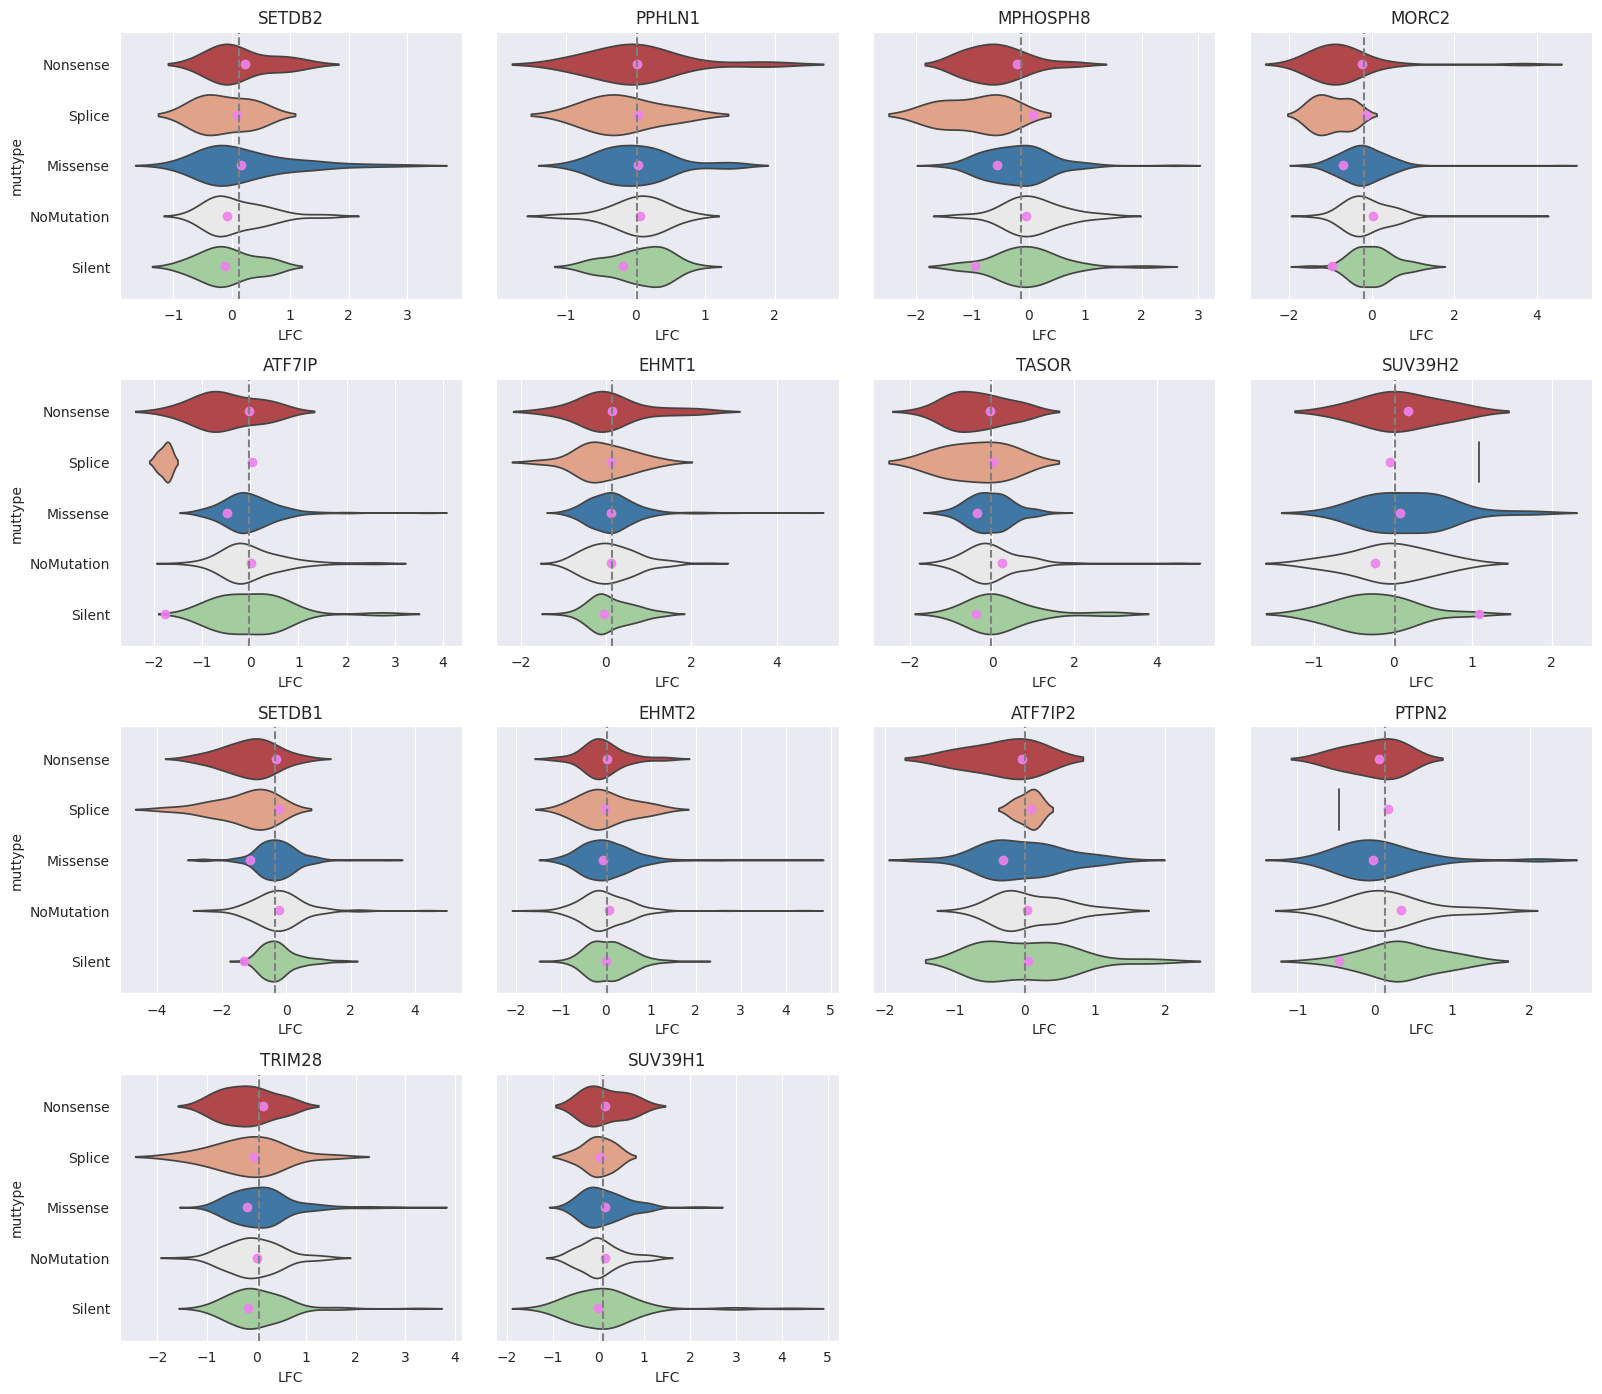

In [12]:
# @title Violin Plots
# @markdown Run this cell to generate violin plots showing the LFC distribution
# @markdown for each gene. These will be saved in the **plots** folder.

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

plot_dim = math.ceil(math.sqrt(len(unique_genes)))
fig, axes = plt.subplots(nrows=plot_dim, ncols=plot_dim, sharex=False, sharey=True,\
                         figsize=(19,17), gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

pal = ['#c13639', '#f09c7b', '#2f79b5', '#e9e9e9', '#9cd597']
for idx, current_gene in enumerate(unique_genes):
    df_current_gene = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # ensure all expected mutation types are present, even if they have no counts
    expected_muttypes = ["Nonsense", "Splice", "Missense", "NoMutation", "Silent"]
    for muttype in expected_muttypes:
        if muttype not in df_current_gene['muttype'].unique():
            df_current_gene = pd.concat([df_current_gene, pd.DataFrame({'LFC': [np.nan], 'muttype': [muttype]})], ignore_index=True)

    Means = df_current_gene.groupby('muttype')['LFC'].mean()
    STDs = df_current_gene.groupby('muttype')['LFC'].std()
    Medians = df_current_gene.groupby('muttype')['LFC'].median()

    print("{}: Mean + STD".format(current_gene))
    print("Missense: {} + {}".format(round(Means['Missense'], 4), round(STDs['Missense'], 4))) # Access by label for robustness
    print("NoMutation: {} + {}".format(round(Means['NoMutation'], 4), round(STDs['NoMutation'], 4)))
    print("Nonsense: {} + {}".format(round(Means['Nonsense'], 4), round(STDs['Nonsense'], 4)))
    print("Silent: {} + {}".format(round(Means['Silent'], 4), round(STDs['Silent'], 4)))
    print("Splice: {} + {}".format(round(Means['Splice'], 4), round(STDs['Splice'], 4)))
    print()

    ax = axes.flatten()[idx]
    df_current_gene['muttype'] = pd.Categorical(df_current_gene['muttype'], ["Nonsense", "Splice", "Missense", "NoMutation", "Silent"])
    df_current_gene.sort_values(by=['muttype'], inplace=True)
    df_current_gene.reset_index(drop=True, inplace=True)
    sns.violinplot(ax=ax,data=df_current_gene, x="LFC", y="muttype", inner=None, hue="muttype",\
                   palette=pal).set(title=current_gene)

    ax.axvline(df_current_gene["LFC"].mean(), c="gray", linestyle="dashed")
    ax.scatter(y=range(len(Means)),x=Means,c="violet", alpha=.9)

# remove empty plots
for ax in axes.flatten()[len(unique_genes):]:
    fig.delaxes(ax)

plt.savefig(workdir + "/plots/" + input_screen + "_muttype_LFC_dist.pdf", dpi=300)
if download == 'Yes':
    files.download(workdir + "/plots/" + input_screen + "_muttype_LFC_dist.pdf")

# Hypothesis 1
There is a significant difference in the signal (LFC) between knockout (nonsense/splice) mutations and silent/no mutations per screen, per gene

In [ ]:
# @title Mann-Whiteney Tests
# @markdown Run this cell to perform Mann-Whiteney tests for the following configurations:
# @markdown - nonsense vs. missense
# @markdown - nonsense vs. no mutation
# @markdown - nonsense vs. silent
# @markdown - splice vs. missense
# @markdown - splice vs. no mutation
# @markdown - splice vs. silent
# @markdown - missense vs. splice + nonsense
# @markdown - no mutation vs. splice + nonsense
# @markdown - silent vs. splice + nonsense
# @markdown - missense vs. silent + no mutation
# @markdown - nonsense vs. silent + no mutation
# @markdown - splice vs. silent + no mutation
# @markdown - no mutation vs. silent (negative control)
# @markdown - nonsense vs. splice (negative control)
# @markdown - splice + nonsense vs. silent + no mutation
# @markdown
# @markdown
# @markdown The results will be saved as a TSV file in the **qc_validation** folder. \
# @markdown Would you like to download the results?
download ='No' #@param ["Yes", "No"]

# columns for output dataframe
col_names = ['screenid', 'gene_name', 'n_missense', 'n_silent', 'n_nonsense', \
             'n_nomutation', 'n_splice', 'U_nonsense_vs_missense', 'p_nonsense_vs_missense', \
             'U_nonsense_vs_nomutation', 'p_nonsense_vs_nomutation', 'U_nonsense_vs_silent', \
             'p_nonsense_vs_silent', 'U_splice_vs_missene', 'p_splice_vs_missense', \
             'U_splice_vs_nomutation', 'p_splice_vs_nomutation', 'U_splice_vs_silent', \
             'p_splice_vs_silent', 'U_missense_vs_splice_nonsense', 'p_missense_vs_splice_nonsense', \
             'U_nomutation_vs_splice_nonsense', 'p_nomutation_vs_splice_nonsense', \
             'U_silent_vs_splice_nonsense', 'p_silent_vs_splice_nonsense', \
             'U_missense_vs_silent_nomutation', 'p_missense_vs_silent_nomutation', \
             'U_nonsense_vs_silent_nomutation', 'p_nonsense_vs_silent_nomutation', \
             'U_splice_vs_silent_nomutation', 'p_splice_vs_silent_nomutation', \
             'U_nomutation_vs_silent', 'p_nomutation_vs_silent', 'U_nonsense_vs_splice', \
             'p_nonsense_vs_splice', 'U_splice_nonsense_vs_silent_nomutation', \
             'p_splice_nonsense_vs_silent_nomutation']

# create dataframe to store results of tests
df_output = pd.DataFrame(columns=col_names)

for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # dataframe for missense data
    df_InputGene_missense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Missense']
    df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)

    # dataframe for silent data
    df_InputGene_silent = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Silent']
    df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)

    # dataframe for nonsense data
    df_InputGene_nonsense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Nonsense']
    df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)

    # dataframe for no mutation data
    df_InputGene_nomutation = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'NoMutation']
    df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)

    # dataframe for splice data
    df_InputGene_splice = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Splice']
    df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)

    # create new row for each gene to be inserted into df_output
    new_row = {}
    for key in col_names:
        new_row[key] = None

    new_row['screenid'] = input_screen
    new_row['gene_name'] = current_gene
    new_row['n_missense'] = len(df_InputGene_missense)
    new_row['n_silent'] = len(df_InputGene_silent)
    new_row['n_nonsense'] = len(df_InputGene_nonsense)
    new_row['n_nomutation'] = len(df_InputGene_nomutation)
    new_row['n_splice'] = len(df_InputGene_splice)

    # nonsense vs. missense
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_missense'] = U1
        new_row['p_nonsense_vs_missense'] = p
    else:
        new_row['U_nonsense_vs_missense'] = -999
        new_row['p_nonsense_vs_missense'] = -999

    # nonsense vs. no mutation
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_nomutation'] = U1
        new_row['p_nonsense_vs_nomutation'] = p
    else:
        new_row['U_nonsense_vs_nomutation'] = -999
        new_row['p_nonsense_vs_nomutation'] = -999

    # nonsense vs. silent
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_silent'] = U1
        new_row['p_nonsense_vs_silent'] = p
    else:
        new_row['U_nonsense_vs_silent'] = -999
        new_row['p_nonsense_vs_silent'] = -999

    # splice vs. missense
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_splice_vs_missene'] = U1
        new_row['p_splice_vs_missense'] = p
    else:
        new_row['U_splice_vs_missene'] = -999
        new_row['p_splice_vs_missense'] = -999

    # splice vs. no mutation
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_splice_vs_nomutation'] = U1
        new_row['p_splice_vs_nomutation'] = p
    else:
        new_row['U_splice_vs_nomutation'] = -999
        new_row['p_splice_vs_nomutation'] = -999

    # splice vs. silent
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_splice_vs_silent'] = U1
        new_row['p_splice_vs_silent'] = p
    else:
        new_row['U_splice_vs_silent'] = -999
        new_row['p_splice_vs_silent'] = -999

    # missense vs. splice + nonsense
    df_splice_nonsense = pd.concat([df_InputGene_nonsense, df_InputGene_splice])
    if len(df_InputGene_missense) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_missense_vs_splice_nonsense'] = U1
        new_row['p_missense_vs_splice_nonsense'] = p
    else:
        new_row['U_missense_vs_splice_nonsense'] = -999
        new_row['p_missense_vs_splice_nonsense'] = -999

    # no mutation vs. splice + nonsense
    if len(df_InputGene_nomutation) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_nomutation_vs_splice_nonsense'] = U1
        new_row['p_nomutation_vs_splice_nonsense'] = p
    else:
        new_row['U_nomutation_vs_splice_nonsense'] = -999
        new_row['p_nomutation_vs_splice_nonsense'] = -999

    # silent vs. splice + nonsense
    if len(df_InputGene_silent) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_silent_vs_splice_nonsense'] = U1
        new_row['p_silent_vs_splice_nonsense'] = p
    else:
        new_row['U_silent_vs_splice_nonsense'] = -999
        new_row['p_silent_vs_splice_nonsense'] = -999

    # missense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_InputGene_missense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_missense_vs_silent_nomutation'] = U1
        new_row['p_missense_vs_silent_nomutation'] = p
    else:
        new_row['U_missense_vs_silent_nomutation'] = -999
        new_row['p_missense_vs_silent_nomutation'] = -999

    # nonsense vs. silent + no mutation
    if len(df_InputGene_nonsense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_nonsense['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_silent_nomutation'] = U1
        new_row['p_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['U_nonsense_vs_silent_nomutation'] = -999
        new_row['p_nonsense_vs_silent_nomutation'] = -999

    # splice vs. silent + no mutation
    if len(df_InputGene_splice) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_splice['LFC'], method="asymptotic")
        new_row['U_splice_vs_silent_nomutation'] = U1
        new_row['p_splice_vs_silent_nomutation'] = p
    else:
        new_row['U_splice_vs_silent_nomutation'] = -999
        new_row['p_splice_vs_silent_nomutation'] = -999

    # no mutation vs. silent (negative control)
    if len(df_InputGene_nomutation) > 0 and len(df_InputGene_silent) > 0:
        U1, p = mannwhitneyu(df_InputGene_nomutation['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_nomutation_vs_silent'] = U1
        new_row['p_nomutation_vs_silent'] = p
    else:
        new_row['U_nomutation_vs_silent'] = -999
        new_row['p_nomutation_vs_silent'] = -999

    # nonsense vs. splice (negative control)
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_splice['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_splice'] = U1
        new_row['p_nonsense_vs_splice'] = p
    else:
        new_row['U_nonsense_vs_splice'] = -999
        new_row['p_nonsense_vs_splice'] = -999

    # splice + nonsense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_splice_nonsense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_silent_nomutation['LFC'], method="asymptotic")
        new_row['U_splice_nonsense_vs_silent_nomutation'] = U1
        new_row['p_splice_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['U_splice_nonsense_vs_silent_nomutation'] = -999
        new_row['p_splice_nonsense_vs_silent_nomutation'] = -999

    # add new row to dataframe
    df_output.loc[len(df_output)] = new_row

# save file to qc_validation folder
df_output.to_csv(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_1.tsv", sep = '\t', index=False)

if download == 'Yes':
    files.download(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_1.tsv")

df_output.head(len(unique_genes))

,screenid,gene_name,n_missense,n_silent,n_nonsense,n_nomutation,n_splice,U_nonsense_vs_missense,p_nonsense_vs_missense,U_nonsense_vs_nomutation,...,U_nonsense_vs_silent_nomutation,p_nonsense_vs_silent_nomutation,U_splice_vs_silent_nomutation,p_splice_vs_silent_nomutation,U_nomutation_vs_silent,p_nomutation_vs_silent,U_nonsense_vs_splice,p_nonsense_vs_splice,U_splice_nonsense_vs_silent_nomutation,p_splice_nonsense_vs_silent_nomutation
0,Human_InVitro_SW480_Apobec_D14_Input,SETDB2,57,23,11,61,5,330.0,7.898715e-01,368.0,...,395.0,4.392456e-01,257.0,0.407380,815.0,0.256992,36.0,0.364774,692.0,8.545283e-01
1,Human_InVitro_SW480_Apobec_D14_Input,PPHLN1,74,28,13,33,5,463.0,8.349444e-01,187.0,...,455.0,4.100144e-01,202.0,0.235058,436.0,0.712074,40.0,0.490188,441.0,2.089392e-01
2,Human_InVitro_SW480_Apobec_D14_Input,MPHOSPH8,131,42,16,74,5,644.0,1.208374e-02,214.0,...,1488.0,9.578019e-05,535.0,0.001452,1764.0,0.228783,54.0,0.264657,413.0,1.534800e-06
3,Human_InVitro_SW480_Apobec_D14_Input,MORC2,273,109,32,147,11,1877.5,1.322843e-07,848.0,...,6876.0,3.906854e-10,2567.0,0.000004,6520.0,0.010920,202.0,0.477781,1565.0,6.016578e-14
4,Human_InVitro_SW480_Apobec_D14_Input,ATF7IP,216,32,15,130,3,958.0,8.215608e-03,560.0,...,1725.0,7.282895e-03,486.0,0.003101,2127.0,0.844911,45.0,0.009152,705.0,3.331014e-04
5,Human_InVitro_SW480_Apobec_D14_Input,EHMT1,454,151,24,137,21,4963.5,4.630095e-01,1540.0,...,3704.0,5.599612e-01,3487.0,0.241967,10150.0,0.784520,282.0,0.502112,5769.0,2.368139e-01
6,Human_InVitro_SW480_Apobec_D14_Input,TASOR,187,43,25,116,4,1657.5,1.833064e-02,1012.0,...,2634.0,9.065415e-03,407.0,0.342488,2124.0,0.151917,49.0,0.974770,1570.0,6.383313e-03
7,Human_InVitro_SW480_Apobec_D14_Input,SUV39H2,31,17,6,35,1,86.0,7.888074e-01,122.0,...,119.0,3.513687e-01,0.0,0.095510,370.0,0.160156,0.0,0.211300,245.0,1.429089e-01
8,Human_InVitro_SW480_Apobec_D14_Input,SETDB1,345,122,34,168,19,2427.0,1.698422e-08,1191.0,...,7923.0,7.001475e-09,4600.0,0.000001,10293.0,0.949671,338.0,0.787976,2847.0,3.150761e-13
9,Human_InVitro_SW480_Apobec_D14_Input,EHMT2,581,198,37,201,27,9916.5,4.297477e-01,3547.0,...,8194.0,2.681041e-01,5660.0,0.659262,17516.0,0.038589,483.0,0.827812,11682.0,2.746524e-01


In [ ]:
# @title Kolmogorov-Smirnov Tests
# @markdown Run this cell to perform KS tests for the following configurations:
# @markdown - nonsense vs. missense
# @markdown - nonsense vs. no mutation
# @markdown - nonsense vs. silent
# @markdown - splice vs. missense
# @markdown - splice vs. no mutation
# @markdown - splice vs. silent
# @markdown - missense vs. splice + nonsense
# @markdown - no mutation vs. splice + nonsense
# @markdown - silent vs. splice + nonsense
# @markdown - missense vs. silent + no mutation
# @markdown - nonsense vs. silent + no mutation
# @markdown - splice vs. silent + no mutation
# @markdown - no mutation vs. silent (negative control)
# @markdown - nonsense vs. splice (negative control)
# @markdown - splice + nonsense vs. silent + no mutation
# @markdown
# @markdown
# @markdown The results will be saved as a TSV file in the **qc_validation** folder. \
# @markdown Would you like to download the results?
download ='No' #@param ["Yes", "No"]

# columns for output dataframe
col_names = ['screenid', 'gene_name', 'n_missense', 'n_silent', 'n_nonsense', \
             'n_nomutation', 'n_splice', 'D_nonsense_vs_missense', 'p_nonsense_vs_missense', \
             'D_nonsense_vs_nomutation', 'p_nonsense_vs_nomutation', 'D_nonsense_vs_silent', \
             'p_nonsense_vs_silent', 'D_splice_vs_missene', 'p_splice_vs_missense', \
             'D_splice_vs_nomutation', 'p_splice_vs_nomutation', 'D_splice_vs_silent', \
             'p_splice_vs_silent', 'D_missense_vs_splice_nonsense', 'p_missense_vs_splice_nonsense', \
             'D_nomutation_vs_splice_nonsense', 'p_nomutation_vs_splice_nonsense', \
             'D_silent_vs_splice_nonsense', 'p_silent_vs_splice_nonsense', \
             'D_missense_vs_silent_nomutation', 'p_missense_vs_silent_nomutation', \
             'D_nonsense_vs_silent_nomutation', 'p_nonsense_vs_silent_nomutation', \
             'D_splice_vs_silent_nomutation', 'p_splice_vs_silent_nomutation', \
             'D_nomutation_vs_silent', 'p_nomutation_vs_silent', 'D_nonsense_vs_splice', \
             'p_nonsense_vs_splice', 'D_splice_nonsense_vs_silent_nomutation', \
             'p_splice_nonsense_vs_silent_nomutation']

# Create output data frame
df_output = pd.DataFrame(columns=col_names)

for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # dataframe for missense data
    df_InputGene_missense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Missense']
    df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)

    # dataframe for silent data
    df_InputGene_silent = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Silent']
    df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)

    # dataframe for nonsense data
    df_InputGene_nonsense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Nonsense']
    df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)

    # dataframe for splice data
    df_InputGene_splice = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Splice']
    df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)

    # dataframe for no mutation data
    df_InputGene_nomutation = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'NoMutation']
    df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)

    # create new row for each gene to be inserted into df_output
    new_row = {}
    for key in col_names:
        new_row[key] = None

    new_row['screenid'] = input_screen
    new_row['gene_name'] = current_gene
    new_row['n_missense'] = len(df_InputGene_missense)
    new_row['n_silent'] = len(df_InputGene_silent)
    new_row['n_nonsense'] = len(df_InputGene_nonsense)
    new_row['n_nomutation'] = len(df_InputGene_nomutation)
    new_row['n_splice'] = len(df_InputGene_splice)

    # nonsense vs. missense
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_missense['LFC'])
        new_row['D_nonsense_vs_missense'] = D
        new_row['p_nonsense_vs_missense'] = p
    else:
        new_row['D_nonsense_vs_missense'] = -999
        new_row['p_nonsense_vs_missense'] = -999

    # nonsense vs. no mutation
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_nonsense_vs_nomutation'] = D
        new_row['p_nonsense_vs_nomutation'] = p
    else:
        new_row['D_nonsense_vs_nomutation'] = -999
        new_row['p_nonsense_vs_nomutation'] = -999

    # nonsense vs. silent
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_silent['LFC'])
        new_row['D_nonsense_vs_silent'] = D
        new_row['p_nonsense_vs_silent'] = p
    else:
        new_row['D_nonsense_vs_silent'] = -999
        new_row['p_nonsense_vs_silent'] = -999

    # splice vs. missense
    if len(df_InputGene_splice) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_missense['LFC'])
        new_row['D_splice_vs_missene'] = D
        new_row['p_splice_vs_missense'] = p
    else:
        new_row['D_splice_vs_missene'] = -999
        new_row['p_splice_vs_missense'] = -999

    # splice vs. no mutation
    if len(df_InputGene_splice) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_splice_vs_nomutation'] = D
        new_row['p_splice_vs_nomutation'] = p
    else:
        new_row['D_splice_vs_nomutation'] = -999
        new_row['p_splice_vs_nomutation'] = -999

    # splice vs. silent
    if len(df_InputGene_splice) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_silent['LFC'])
        new_row['D_splice_vs_silent'] = D
        new_row['p_splice_vs_silent'] = p
    else:
        new_row['D_splice_vs_silent'] = -999
        new_row['p_splice_vs_silent'] = -999

    # missense vs. splice + nonsense
    df_splice_nonsense = pd.concat([df_InputGene_nonsense, df_InputGene_splice])
    if len(df_splice_nonsense) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_missense['LFC'])
        new_row['D_missense_vs_splice_nonsense'] = D
        new_row['p_missense_vs_splice_nonsense'] = p
    else:
        new_row['D_missense_vs_splice_nonsense'] = -999
        new_row['p_missense_vs_splice_nonsense'] = -999

    # no mutation vs. splice + nonsense
    if len(df_splice_nonsense) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_nomutation_vs_splice_nonsense'] = D
        new_row['p_nomutation_vs_splice_nonsense'] = p
    else:
        new_row['D_nomutation_vs_splice_nonsense'] = -999
        new_row['p_nomutation_vs_splice_nonsense'] = -999

    # silent vs. splice + nonsense
    if len(df_splice_nonsense) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_silent['LFC'])
        new_row['D_silent_vs_splice_nonsense'] = D
        new_row['p_silent_vs_splice_nonsense'] = p
    else:
        new_row['D_silent_vs_splice_nonsense'] = -999
        new_row['p_silent_vs_splice_nonsense'] = -999

    # missense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_silent_nomutation) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_missense['LFC'])
        new_row['D_missense_vs_silent_nomutation'] = D
        new_row['p_missense_vs_silent_nomutation'] = p
    else:
        new_row['D_missense_vs_silent_nomutation'] = -999
        new_row['p_missense_vs_silent_nomutation'] = -999

    # nonsense vs. silent + no mutation
    if len(df_silent_nomutation) > 0 and len(df_InputGene_nonsense) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_nonsense['LFC'])
        new_row['D_nonsense_vs_silent_nomutation'] = D
        new_row['p_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['D_nonsense_vs_silent_nomutation'] = -999
        new_row['p_nonsense_vs_silent_nomutation'] = -999

    # splice vs. silent + no mutation
    if len(df_silent_nomutation) > 0 and len(df_InputGene_splice) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_splice['LFC'])
        new_row['D_splice_vs_silent_nomutation'] = D
        new_row['p_splice_vs_silent_nomutation'] = p
    else:
        new_row['D_splice_vs_silent_nomutation'] = -999
        new_row['p_splice_vs_silent_nomutation'] = -999

    # no mutation vs. silent (negative control)
    if len(df_InputGene_nomutation) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_nomutation['LFC'], df_InputGene_silent['LFC'])
        new_row['D_nomutation_vs_silent'] = D
        new_row['p_nomutation_vs_silent'] = p
    else:
        new_row['D_nomutation_vs_silent'] = -999
        new_row['p_nomutation_vs_silent'] = -999

    # nonsense vs. splice (negative control)
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_splice) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_splice['LFC'])
        new_row['D_nonsense_vs_splice'] = D
        new_row['p_nonsense_vs_splice'] = p
    else:
        new_row['D_nonsense_vs_splice'] = -999
        new_row['p_nonsense_vs_splice'] = -999

    # splice + nonsense vs. silent + no mutation
    if len(df_splice_nonsense) > 0 and len(df_silent_nomutation) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_silent_nomutation['LFC'])
        new_row['D_splice_nonsense_vs_silent_nomutation'] = D
        new_row['p_splice_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['D_splice_nonsense_vs_silent_nomutation'] = -999
        new_row['p_splice_nonsense_vs_silent_nomutation'] = -999

    # add new row to dataframe
    df_output.loc[len(df_output)] = new_row

# save file to qc_validation folder
df_output.to_csv(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_1.tsv", sep='\t', index=False)

if download == 'Yes':
    files.download(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_1.tsv")

df_output.head(len(unique_genes))

,screenid,gene_name,n_missense,n_silent,n_nonsense,n_nomutation,n_splice,D_nonsense_vs_missense,p_nonsense_vs_missense,D_nonsense_vs_nomutation,...,D_nonsense_vs_silent_nomutation,p_nonsense_vs_silent_nomutation,D_splice_vs_silent_nomutation,p_splice_vs_silent_nomutation,D_nomutation_vs_silent,p_nomutation_vs_silent,D_nonsense_vs_splice,p_nonsense_vs_splice,D_splice_nonsense_vs_silent_nomutation,p_splice_nonsense_vs_silent_nomutation
0,Human_InVitro_SW480_Apobec_D14_Input,SETDB2,57,23,11,61,5,0.221691,6.741979e-01,0.228018,...,0.246753,5.139404e-01,0.280952,0.759735,0.188881,0.515165,0.418182,0.484890,0.122024,9.717752e-01
1,Human_InVitro_SW480_Apobec_D14_Input,PPHLN1,74,28,13,33,5,0.122661,9.870950e-01,0.219114,...,0.182850,7.963800e-01,0.439344,0.253656,0.134199,0.902122,0.369231,0.614146,0.250455,2.893949e-01
2,Human_InVitro_SW480_Apobec_D14_Input,MPHOSPH8,131,42,16,74,5,0.348282,4.750812e-02,0.574324,...,0.525862,4.032049e-04,0.836207,0.000428,0.147362,0.546247,0.400000,0.469212,0.585386,3.098276e-06
3,Human_InVitro_SW480_Apobec_D14_Input,MORC2,273,109,32,147,11,0.488439,8.562075e-07,0.530825,...,0.589844,8.304869e-10,0.707031,0.000009,0.191974,0.016659,0.238636,0.633357,0.614008,1.183774e-13
4,Human_InVitro_SW480_Apobec_D14_Input,ATF7IP,216,32,15,130,3,0.458333,3.300741e-03,0.446154,...,0.425926,9.051077e-03,1.000000,0.000003,0.184135,0.302597,1.000000,0.002451,0.487654,5.099774e-04
5,Human_InVitro_SW480_Apobec_D14_Input,EHMT1,454,151,24,137,21,0.158774,5.591649e-01,0.131995,...,0.163194,5.520025e-01,0.237599,0.185578,0.110988,0.307930,0.226190,0.531341,0.190972,1.019309e-01
6,Human_InVitro_SW480_Apobec_D14_Input,TASOR,187,43,25,116,4,0.359786,4.502483e-03,0.345172,...,0.351950,6.660389e-03,0.405660,0.432552,0.175421,0.252174,0.220000,0.983159,0.353936,2.876674e-03
7,Human_InVitro_SW480_Apobec_D14_Input,SUV39H2,31,17,6,35,1,0.279570,7.343882e-01,0.290476,...,0.352564,4.143414e-01,1.000000,0.037736,0.272269,0.306359,1.000000,0.285714,0.376374,2.742686e-01
8,Human_InVitro_SW480_Apobec_D14_Input,SETDB1,345,122,34,168,19,0.527792,1.611032e-08,0.472339,...,0.517647,4.628509e-08,0.531579,0.000033,0.149493,0.074648,0.122291,0.977552,0.522642,8.066926e-12
9,Human_InVitro_SW480_Apobec_D14_Input,EHMT2,581,198,37,201,27,0.181374,1.780963e-01,0.123571,...,0.184786,1.732047e-01,0.112503,0.869486,0.146766,0.023476,0.161161,0.736582,0.139803,2.085554e-01


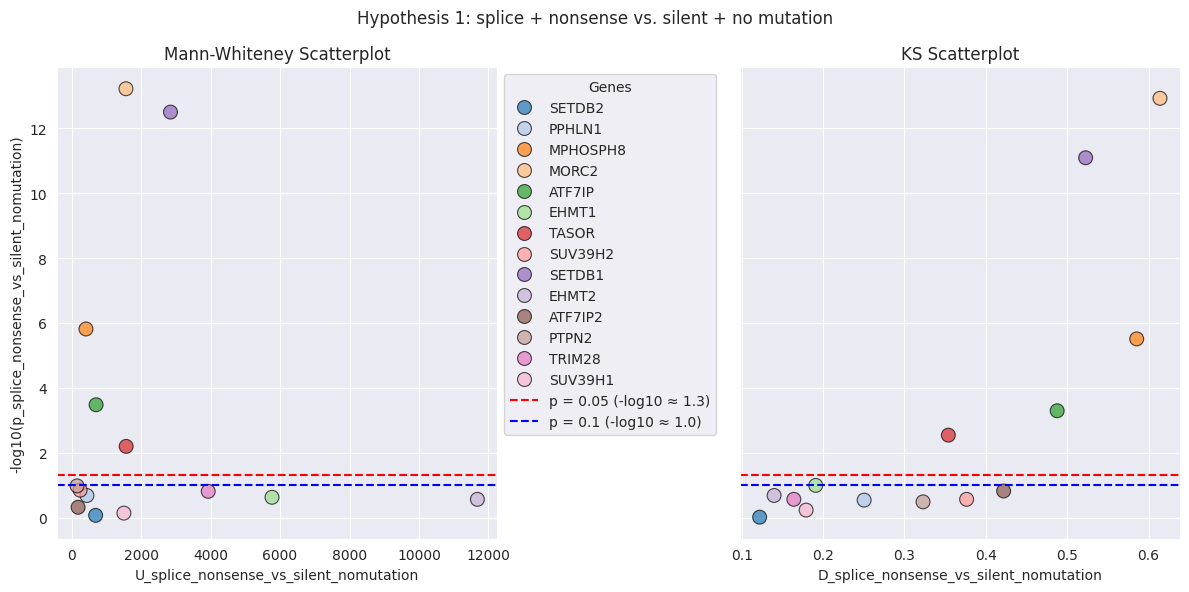

In [ ]:
# @title Visualization of Hypothesis Tests
# @markdown Run this cell to generate scatterplots for the comparison condition
# @markdown specified below. The Mann-Whiteney graph will plot the U value vs. -log10(p)
# @markdown value. The KS graph will do the same, however the x-axis will be the D
# @markdown value instead of U. The scatterplots will be saved to the **plots**
# @markdown folder.
# @markdown ****
# @markdown Which comparison condition would you like to see in the Mann-Whiteney
# @markdown and KS test scatterplots for Hypothesis 1?
comparison_condition ='splice + nonsense vs. silent + no mutation' #@param ["nonsense vs. missense", "nonsense vs. no mutation", "nonsense vs. silent", "splice vs. missense", "splice vs. no mutation", "splice vs. silent", "missense vs. splice + nonsense", "no mutation vs. splice + nonsense", "silent vs. splice + nonsense", "missense vs. silent + no mutation", "nonsense vs. silent + no mutation", "splice vs. silent + no mutation", "no mutation vs. silent", "nonsense vs. splice", "splice + nonsense vs. silent + no mutation"]

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

cases_dictionary = {
    'nonsense vs. missense': '_nonsense_vs_missense',
    'nonsense vs. no mutation': '_nonsense_vs_nomutation',
    'nonsense vs. silent': '_nonsense_vs_silent',
    'splice vs. missense': '_splice_vs_missense',
    'splice vs. no mutation': '_splice_vs_nomutation',
    'splice vs. silent': '_splice_vs_silent',
    'missense vs. splice + nonsense': '_missense_vs_splice_nonsense',
    'no mutation vs. splice + nonsense': '_nomutation_vs_splice_nonsense',
    'silent vs. splice + nonsense': '_silent_vs_splice_nonsense',
    'missense vs. silent + no mutation': '_missense_vs_silent_nomutation',
    'nonsense vs. silent + no mutation': '_nonsense_vs_silent_nomutation',
    'splice vs. silent + no mutation': '_splice_vs_silent_nomutation',
    'no mutation vs. silent': '_nomutation_vs_silent',
    'nonsense vs. splice': '_nonsense_vs_splice',
    'splice + nonsense vs. silent + no mutation': '_splice_nonsense_vs_silent_nomutation'
}
partial_col_header = cases_dictionary[comparison_condition]

# helper function: transform p-values to -log10(p)
def negative_log_transformation(value):
    if pd.notna(value) and value > 0:
        return -np.log10(value)
    return value

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# prepare dataframe for graphing
df_MW_input = pd.read_csv(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_1.tsv", sep='\t')
df_MW_input.replace(-999, pd.NA, inplace=True)  # replace -999 with NaN
x_column = "U" + partial_col_header
y_column = "p" + partial_col_header
df_MW_input[y_column] = df_MW_input[y_column].apply(negative_log_transformation)

# create scatterplot for Mann-Whiteney test
scatter1 = sns.scatterplot(ax=axes[0], data=df_MW_input, x=x_column, y=y_column, \
                           hue="gene_name", palette='tab20', s=100, alpha=0.7, edgecolor='k')
axes[0].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05 (-log10 ≈ 1.3)')
axes[0].axhline(y=-np.log10(0.1), color='blue', linestyle='--', label='p = 0.1 (-log10 ≈ 1.0)')
axes[0].set_ylabel(f'-log10({y_column})')
axes[0].set_title(f'Mann-Whiteney Scatterplot')

# legend for genes
handles, labels = scatter1.get_legend_handles_labels()
axes[0].legend(handles, labels, title="Genes", bbox_to_anchor=(1.0, 1), loc='upper left')

# prepare dataframe for graphing
df_KS_input = pd.read_csv(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_1.tsv", sep='\t')
df_KS_input.replace(-999, pd.NA, inplace=True)  # replace -999 with NaN
x_column = "D" + partial_col_header
y_column = "p" + partial_col_header
df_KS_input[y_column] = df_KS_input[y_column].apply(negative_log_transformation)

# create scatterplot for KS Test
scatter2 = sns.scatterplot(ax=axes[1], data=df_KS_input, x=x_column, y=y_column, \
                           legend=False, hue="gene_name", palette='tab20', s=100, alpha=0.7, edgecolor='k')
axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05 (-log10 ≈ 1.3)')
axes[1].axhline(y=-np.log10(0.1), color='blue', linestyle='--', label='p = 0.1 (-log10 ≈ 1.0)')
axes[1].set_title(f'KS Scatterplot')

fig.suptitle(f"Hypothesis 1: {comparison_condition}")
plt.tight_layout()

# save plot to plots folder
plt.savefig(workdir + "/plots/" + input_screen + "_hypothesis_1_scatterplot.pdf", dpi=300)

if download == 'Yes':
    files.download(workdir + "/plots/" + input_screen + "_hypothesis_1_scatterplot.pdf")

# Hypothesis 2
There's a significant difference in the signal (LFC) between knockout (nonsense/splice) mutations per gene and silent/no mutations from entire screen

In [ ]:
# @title Mann-Whiteney Tests
# @markdown Run this cell to perform Mann-Whiteney tests for the following configurations:
# @markdown - nonsense vs. missense
# @markdown - nonsense vs. no mutation
# @markdown - nonsense vs. silent
# @markdown - splice vs. missense
# @markdown - splice vs. no mutation
# @markdown - splice vs. silent
# @markdown - missense vs. splice + nonsense
# @markdown - no mutation vs. splice + nonsense
# @markdown - silent vs. splice + nonsense
# @markdown - missense vs. silent + no mutation
# @markdown - nonsense vs. silent + no mutation
# @markdown - splice vs. silent + no mutation
# @markdown - no mutation vs. silent (negative control)
# @markdown - nonsense vs. splice (negative control)
# @markdown - splice + nonsense vs. silent + no mutation
# @markdown
# @markdown
# @markdown The results will be saved as a TSV file in the **qc_validation** folder. \
# @markdown Would you like to download the results?
download ='No' #@param ["Yes", "No"]

# columns for output dataframe
col_names = ['screenid', 'gene_name', 'n_missense', 'n_silent', 'n_nonsense', \
             'n_nomutation', 'n_splice', 'U_nonsense_vs_missense', 'p_nonsense_vs_missense', \
             'U_nonsense_vs_nomutation', 'p_nonsense_vs_nomutation', 'U_nonsense_vs_silent', \
             'p_nonsense_vs_silent', 'U_splice_vs_missene', 'p_splice_vs_missense', \
             'U_splice_vs_nomutation', 'p_splice_vs_nomutation', 'U_splice_vs_silent', \
             'p_splice_vs_silent', 'U_missense_vs_splice_nonsense', 'p_missense_vs_splice_nonsense', \
             'U_nomutation_vs_splice_nonsense', 'p_nomutation_vs_splice_nonsense', \
             'U_silent_vs_splice_nonsense', 'p_silent_vs_splice_nonsense', \
             'U_missense_vs_silent_nomutation', 'p_missense_vs_silent_nomutation', \
             'U_nonsense_vs_silent_nomutation', 'p_nonsense_vs_silent_nomutation', \
             'U_splice_vs_silent_nomutation', 'p_splice_vs_silent_nomutation', \
             'U_nomutation_vs_silent', 'p_nomutation_vs_silent', 'U_nonsense_vs_splice', \
             'p_nonsense_vs_splice', 'U_splice_nonsense_vs_silent_nomutation', \
             'p_splice_nonsense_vs_silent_nomutation']

# Create output data frame
df_output = pd.DataFrame(columns=col_names)
df_all_screen_silent = pd.DataFrame()
df_all_screen_nomutation = pd.DataFrame()

# global silent and no mutation LFC collection
for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # accumulate no mutation scores across all genes
    df_InputGene_nomutation = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'NoMutation']
    df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)

    df_all_screen_nomutation = pd.concat([df_all_screen_nomutation, df_InputGene_nomutation])
    df_all_screen_nomutation = df_all_screen_nomutation.reset_index(drop=True)

    # accumulate silent scores across all genes
    df_InputGene_silent = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Silent']
    df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)

    df_all_screen_silent = pd.concat([df_all_screen_silent, df_InputGene_silent])
    df_all_screen_silent = df_all_screen_silent.reset_index(drop=True)

for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # dataframe for missense data
    df_InputGene_missense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Missense']
    df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)

    # dataframe for nonsense data
    df_InputGene_nonsense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Nonsense']
    df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)

    # dataframe for splice data
    df_InputGene_splice = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Splice']
    df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)

    df_InputGene_nomutation = df_all_screen_nomutation
    df_InputGene_silent = df_all_screen_silent

    # create new row for each gene to be inserted into df_output
    new_row = {}
    for key in col_names:
        new_row[key] = None

    new_row['screenid'] = input_screen
    new_row['gene_name'] = current_gene
    new_row['n_missense'] = len(df_InputGene_missense)
    new_row['n_silent'] = len(df_InputGene_silent)
    new_row['n_nonsense'] = len(df_InputGene_nonsense)
    new_row['n_nomutation'] = len(df_InputGene_nomutation)
    new_row['n_splice'] = len(df_InputGene_splice)

   # nonsense vs. missense
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_missense'] = U1
        new_row['p_nonsense_vs_missense'] = p
    else:
        new_row['U_nonsense_vs_missense'] = -999
        new_row['p_nonsense_vs_missense'] = -999

    # nonsense vs. no mutation
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_nomutation'] = U1
        new_row['p_nonsense_vs_nomutation'] = p
    else:
        new_row['U_nonsense_vs_nomutation'] = -999
        new_row['p_nonsense_vs_nomutation'] = -999

    # nonsense vs. silent
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_silent'] = U1
        new_row['p_nonsense_vs_silent'] = p
    else:
        new_row['U_nonsense_vs_silent'] = -999
        new_row['p_nonsense_vs_silent'] = -999

    # splice vs. missense
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_splice_vs_missene'] = U1
        new_row['p_splice_vs_missense'] = p
    else:
        new_row['U_splice_vs_missene'] = -999
        new_row['p_splice_vs_missense'] = -999

    # splice vs. no mutation
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_splice_vs_nomutation'] = U1
        new_row['p_splice_vs_nomutation'] = p
    else:
        new_row['U_splice_vs_nomutation'] = -999
        new_row['p_splice_vs_nomutation'] = -999

    # splice vs. silent
    if len(df_InputGene_splice) > 0:
        U1, p = mannwhitneyu(df_InputGene_splice['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_splice_vs_silent'] = U1
        new_row['p_splice_vs_silent'] = p
    else:
        new_row['U_splice_vs_silent'] = -999
        new_row['p_splice_vs_silent'] = -999

    # missense vs. splice + nonsense
    df_splice_nonsense = pd.concat([df_InputGene_nonsense, df_InputGene_splice])
    if len(df_InputGene_missense) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_missense_vs_splice_nonsense'] = U1
        new_row['p_missense_vs_splice_nonsense'] = p
    else:
        new_row['U_missense_vs_splice_nonsense'] = -999
        new_row['p_missense_vs_splice_nonsense'] = -999

    # no mutation vs. splice + nonsense
    if len(df_InputGene_nomutation) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_nomutation['LFC'], method="asymptotic")
        new_row['U_nomutation_vs_splice_nonsense'] = U1
        new_row['p_nomutation_vs_splice_nonsense'] = p
    else:
        new_row['U_nomutation_vs_splice_nonsense'] = -999
        new_row['p_nomutation_vs_splice_nonsense'] = -999

    # silent vs. splice + nonsense
    if len(df_InputGene_silent) > 0 and len(df_splice_nonsense) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_silent_vs_splice_nonsense'] = U1
        new_row['p_silent_vs_splice_nonsense'] = p
    else:
        new_row['U_silent_vs_splice_nonsense'] = -999
        new_row['p_silent_vs_splice_nonsense'] = -999

    # missense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_InputGene_missense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_missense['LFC'], method="asymptotic")
        new_row['U_missense_vs_silent_nomutation'] = U1
        new_row['p_missense_vs_silent_nomutation'] = p
    else:
        new_row['U_missense_vs_silent_nomutation'] = -999
        new_row['p_missense_vs_silent_nomutation'] = -999

    # nonsense vs. silent + no mutation
    if len(df_InputGene_nonsense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_nonsense['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_silent_nomutation'] = U1
        new_row['p_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['U_nonsense_vs_silent_nomutation'] = -999
        new_row['p_nonsense_vs_silent_nomutation'] = -999

    # splice vs. silent + no mutation
    if len(df_InputGene_splice) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_silent_nomutation['LFC'], df_InputGene_splice['LFC'], method="asymptotic")
        new_row['U_splice_vs_silent_nomutation'] = U1
        new_row['p_splice_vs_silent_nomutation'] = p
    else:
        new_row['U_splice_vs_silent_nomutation'] = -999
        new_row['p_splice_vs_silent_nomutation'] = -999

    # no mutation vs. silent (negative control)
    if len(df_InputGene_nomutation) > 0 and len(df_InputGene_silent) > 0:
        U1, p = mannwhitneyu(df_InputGene_nomutation['LFC'], df_InputGene_silent['LFC'], method="asymptotic")
        new_row['U_nomutation_vs_silent'] = U1
        new_row['p_nomutation_vs_silent'] = p
    else:
        new_row['U_nomutation_vs_silent'] = -999
        new_row['p_nomutation_vs_silent'] = -999

    # nonsense vs. splice (negative control)
    if len(df_InputGene_nonsense) > 0:
        U1, p = mannwhitneyu(df_InputGene_nonsense['LFC'], df_InputGene_splice['LFC'], method="asymptotic")
        new_row['U_nonsense_vs_splice'] = U1
        new_row['p_nonsense_vs_splice'] = p
    else:
        new_row['U_nonsense_vs_splice'] = -999
        new_row['p_nonsense_vs_splice'] = -999

    # splice + nonsense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_splice_nonsense) > 0 and len(df_silent_nomutation) > 0:
        U1, p = mannwhitneyu(df_splice_nonsense['LFC'], df_silent_nomutation['LFC'], method="asymptotic")
        new_row['U_splice_nonsense_vs_silent_nomutation'] = U1
        new_row['p_splice_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['U_splice_nonsense_vs_silent_nomutation'] = -999
        new_row['p_splice_nonsense_vs_silent_nomutation'] = -999

    # add new row to dataframe
    df_output.loc[len(df_output)] = new_row

# save file to qc_validation folder
df_output.to_csv(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_2.tsv", sep = '\t', index=False)

if download == 'Yes':
    files.download(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_2.tsv")

df_output.head(len(unique_genes))

,screenid,gene_name,n_missense,n_silent,n_nonsense,n_nomutation,n_splice,U_nonsense_vs_missense,p_nonsense_vs_missense,U_nonsense_vs_nomutation,...,U_nonsense_vs_silent_nomutation,p_nonsense_vs_silent_nomutation,U_splice_vs_silent_nomutation,p_splice_vs_silent_nomutation,U_nomutation_vs_silent,p_nomutation_vs_silent,U_nonsense_vs_splice,p_nonsense_vs_splice,U_splice_nonsense_vs_silent_nomutation,p_splice_nonsense_vs_silent_nomutation
0,Human_InVitro_SW480_Apobec_D14_Input,SETDB2,57,1009,11,1349,5,330.0,7.898715e-01,8765.0,...,10896.5,3.599517e-01,6638.0,6.261172e-01,650795.0,0.068724,36.0,0.364774,20193.5,6.267166e-01
1,Human_InVitro_SW480_Apobec_D14_Input,PPHLN1,74,1009,13,1349,5,463.0,8.349444e-01,9012.0,...,15240.5,9.721298e-01,6986.0,4.742736e-01,650795.0,0.068724,40.0,0.490188,20217.5,7.291477e-01
2,Human_InVitro_SW480_Apobec_D14_Input,MPHOSPH8,131,1009,16,1349,5,644.0,1.208374e-02,4948.0,...,29431.0,1.102469e-04,10631.0,1.888380e-03,650795.0,0.068724,54.0,0.264657,9456.0,1.045058e-06
3,Human_InVitro_SW480_Apobec_D14_Input,MORC2,273,1009,32,1349,11,1877.5,1.322843e-07,6781.0,...,64097.0,1.042727e-11,23897.0,1.378971e-06,650795.0,0.068724,202.0,0.477781,13400.0,1.244478e-16
4,Human_InVitro_SW480_Apobec_D14_Input,ATF7IP,216,1009,15,1349,3,958.0,8.215608e-03,6024.0,...,25148.5,4.783239e-03,7066.0,2.787440e-03,650795.0,0.068724,45.0,0.009152,10229.5,1.500901e-04
5,Human_InVitro_SW480_Apobec_D14_Input,EHMT1,454,1009,24,1349,21,4963.5,4.630095e-01,17164.0,...,27094.0,7.200397e-01,25793.0,7.415623e-01,650795.0,0.068724,282.0,0.502112,53223.0,9.710196e-01
6,Human_InVitro_SW480_Apobec_D14_Input,TASOR,187,1009,25,1349,4,1657.5,1.833064e-02,11887.0,...,38646.5,7.365263e-03,5944.0,3.677498e-01,650795.0,0.068724,49.0,0.974770,23791.5,4.817437e-03
7,Human_InVitro_SW480_Apobec_D14_Input,SUV39H2,31,1009,6,1349,1,86.0,7.888074e-01,4707.0,...,6078.0,5.510628e-01,103.0,1.142601e-01,650795.0,0.068724,0.0,0.211300,10325.0,2.508535e-01
8,Human_InVitro_SW480_Apobec_D14_Input,SETDB1,345,1009,34,1349,19,2427.0,1.698422e-08,5820.0,...,70419.5,3.294659e-14,41153.0,3.109716e-10,650795.0,0.068724,338.0,0.787976,13401.5,1.199842e-22
9,Human_InVitro_SW480_Apobec_D14_Input,EHMT2,581,1009,37,1349,27,9916.5,4.297477e-01,24081.0,...,46075.5,5.568797e-01,32091.0,9.423048e-01,650795.0,0.068724,483.0,0.827812,72745.5,6.234745e-01


In [ ]:
# @title Kolmogorov-Smirnov Tests
# @markdown Run this cell to perform KS tests for the following configurations:
# @markdown - nonsense vs. missense
# @markdown - nonsense vs. no mutation
# @markdown - nonsense vs. silent
# @markdown - splice vs. missense
# @markdown - splice vs. no mutation
# @markdown - splice vs. silent
# @markdown - missense vs. splice + nonsense
# @markdown - no mutation vs. splice + nonsense
# @markdown - silent vs. splice + nonsense
# @markdown - missense vs. silent + no mutation
# @markdown - nonsense vs. silent + no mutation
# @markdown - splice vs. silent + no mutation
# @markdown - no mutation vs. silent (negative control)
# @markdown - nonsense vs. splice (negative control)
# @markdown - splice + nonsense vs. silent + no mutation
# @markdown
# @markdown
# @markdown The results will be saved as a TSV file in the **qc_validation** folder. \
# @markdown Would you like to download the results?
download ='No' #@param ["Yes", "No"]

# columns for output dataframe
col_names = ['screenid', 'gene_name', 'n_missense', 'n_silent', 'n_nonsense', \
             'n_nomutation', 'n_splice', 'D_nonsense_vs_missense', 'p_nonsense_vs_missense', \
             'D_nonsense_vs_nomutation', 'p_nonsense_vs_nomutation', 'D_nonsense_vs_silent', \
             'p_nonsense_vs_silent', 'D_splice_vs_missene', 'p_splice_vs_missense', \
             'D_splice_vs_nomutation', 'p_splice_vs_nomutation', 'D_splice_vs_silent', \
             'p_splice_vs_silent', 'D_missense_vs_splice_nonsense', 'p_missense_vs_splice_nonsense', \
             'D_nomutation_vs_splice_nonsense', 'p_nomutation_vs_splice_nonsense', \
             'D_silent_vs_splice_nonsense', 'p_silent_vs_splice_nonsense', \
             'D_missense_vs_silent_nomutation', 'p_missense_vs_silent_nomutation', \
             'D_nonsense_vs_silent_nomutation', 'p_nonsense_vs_silent_nomutation', \
             'D_splice_vs_silent_nomutation', 'p_splice_vs_silent_nomutation', \
             'D_nomutation_vs_silent', 'p_nomutation_vs_silent', 'D_nonsense_vs_splice', \
             'p_nonsense_vs_splice', 'D_splice_nonsense_vs_silent_nomutation', \
             'p_splice_nonsense_vs_silent_nomutation']

# Create output data frame
df_output = pd.DataFrame(columns=col_names)
df_all_screen_silent = pd.DataFrame()
df_all_screen_nomutation = pd.DataFrame()
for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # accumulate no mutation scores across all genes
    df_InputGene_nomutation = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'NoMutation']
    df_InputGene_nomutation = df_InputGene_nomutation.reset_index(drop=True)

    df_all_screen_nomutation = pd.concat([df_all_screen_nomutation, df_InputGene_nomutation])
    df_all_screen_nomutation = df_all_screen_nomutation.reset_index(drop=True)

    # accumulate silent scores across all genes
    df_InputGene_silent = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Silent']
    df_InputGene_silent = df_InputGene_silent.reset_index(drop=True)

    df_all_screen_silent = pd.concat([df_all_screen_silent, df_InputGene_silent])
    df_all_screen_silent = df_all_screen_silent.reset_index(drop=True)

for current_gene in unique_genes:
    df_InputGene_edits = pd.read_csv(workdir + "/screendata/" + current_gene + "_" + input_screen + "_edits_list.tsv", sep='\t')

    # dataframe for missense data
    df_InputGene_missense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Missense']
    df_InputGene_missense = df_InputGene_missense.reset_index(drop=True)

    # dataframe for nonsense data
    df_InputGene_nonsense = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Nonsense']
    df_InputGene_nonsense = df_InputGene_nonsense.reset_index(drop=True)

    # dataframe for splice data
    df_InputGene_splice = df_InputGene_edits.loc[df_InputGene_edits['muttype'] == 'Splice']
    df_InputGene_splice = df_InputGene_splice.reset_index(drop=True)

    df_InputGene_nomutation = df_all_screen_nomutation
    df_InputGene_silent = df_all_screen_silent

    # create new row for each gene to be inserted into df_output
    new_row = {}
    for key in col_names:
        new_row[key] = None

    new_row['screenid'] = input_screen
    new_row['gene_name'] = current_gene
    new_row['n_missense'] = len(df_InputGene_missense)
    new_row['n_silent'] = len(df_InputGene_silent)
    new_row['n_nonsense'] = len(df_InputGene_nonsense)
    new_row['n_nomutation'] = len(df_InputGene_nomutation)
    new_row['n_splice'] = len(df_InputGene_splice)

    # nonsense vs. missense
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_missense['LFC'])
        new_row['D_nonsense_vs_missense'] = D
        new_row['p_nonsense_vs_missense'] = p
    else:
        new_row['D_nonsense_vs_missense'] = -999
        new_row['p_nonsense_vs_missense'] = -999

    # nonsense vs. no mutation
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_nonsense_vs_nomutation'] = D
        new_row['p_nonsense_vs_nomutation'] = p
    else:
        new_row['D_nonsense_vs_nomutation'] = -999
        new_row['p_nonsense_vs_nomutation'] = -999

    # nonsense vs. silent
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_silent['LFC'])
        new_row['D_nonsense_vs_silent'] = D
        new_row['p_nonsense_vs_silent'] = p
    else:
        new_row['D_nonsense_vs_silent'] = -999
        new_row['p_nonsense_vs_silent'] = -999

    # splice vs. missense
    if len(df_InputGene_splice) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_missense['LFC'])
        new_row['D_splice_vs_missene'] = D
        new_row['p_splice_vs_missense'] = p
    else:
        new_row['D_splice_vs_missene'] = -999
        new_row['p_splice_vs_missense'] = -999

    # splice vs. no mutation
    if len(df_InputGene_splice) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_splice_vs_nomutation'] = D
        new_row['p_splice_vs_nomutation'] = p
    else:
        new_row['D_splice_vs_nomutation'] = -999
        new_row['p_splice_vs_nomutation'] = -999

    # splice vs. silent
    if len(df_InputGene_splice) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_splice['LFC'], df_InputGene_silent['LFC'])
        new_row['D_splice_vs_silent'] = D
        new_row['p_splice_vs_silent'] = p
    else:
        new_row['D_splice_vs_silent'] = -999
        new_row['p_splice_vs_silent'] = -999

    # missense vs. splice + nonsense
    df_splice_nonsense = pd.concat([df_InputGene_nonsense, df_InputGene_splice])
    if len(df_splice_nonsense) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_missense['LFC'])
        new_row['D_missense_vs_splice_nonsense'] = D
        new_row['p_missense_vs_splice_nonsense'] = p
    else:
        new_row['D_missense_vs_splice_nonsense'] = -999
        new_row['p_missense_vs_splice_nonsense'] = -999

    # no mutation vs. splice + nonsense
    if len(df_splice_nonsense) > 0 and len(df_InputGene_nomutation) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_nomutation['LFC'])
        new_row['D_nomutation_vs_splice_nonsense'] = D
        new_row['p_nomutation_vs_splice_nonsense'] = p
    else:
        new_row['D_nomutation_vs_splice_nonsense'] = -999
        new_row['p_nomutation_vs_splice_nonsense'] = -999

    # silent vs. splice + nonsense
    if len(df_splice_nonsense) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_InputGene_silent['LFC'])
        new_row['D_silent_vs_splice_nonsense'] = D
        new_row['p_silent_vs_splice_nonsense'] = p
    else:
        new_row['D_silent_vs_splice_nonsense'] = -999
        new_row['p_silent_vs_splice_nonsense'] = -999

    # missense vs. silent + no mutation
    df_silent_nomutation = pd.concat([df_InputGene_silent, df_InputGene_nomutation])
    if len(df_silent_nomutation) > 0 and len(df_InputGene_missense) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_missense['LFC'])
        new_row['D_missense_vs_silent_nomutation'] = D
        new_row['p_missense_vs_silent_nomutation'] = p
    else:
        new_row['D_missense_vs_silent_nomutation'] = -999
        new_row['p_missense_vs_silent_nomutation'] = -999

    # nonsense vs. silent + no mutation
    if len(df_silent_nomutation) > 0 and len(df_InputGene_nonsense) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_nonsense['LFC'])
        new_row['D_nonsense_vs_silent_nomutation'] = D
        new_row['p_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['D_nonsense_vs_silent_nomutation'] = -999
        new_row['p_nonsense_vs_silent_nomutation'] = -999

    # splice vs. silent + no mutation
    if len(df_silent_nomutation) > 0 and len(df_InputGene_splice) > 0:
        D, p = ks_2samp(df_silent_nomutation['LFC'], df_InputGene_splice['LFC'])
        new_row['D_splice_vs_silent_nomutation'] = D
        new_row['p_splice_vs_silent_nomutation'] = p
    else:
        new_row['D_splice_vs_silent_nomutation'] = -999
        new_row['p_splice_vs_silent_nomutation'] = -999

    # no mutation vs. silent (negative control)
    if len(df_InputGene_nomutation) > 0 and len(df_InputGene_silent) > 0:
        D, p = ks_2samp(df_InputGene_nomutation['LFC'], df_InputGene_silent['LFC'])
        new_row['D_nomutation_vs_silent'] = D
        new_row['p_nomutation_vs_silent'] = p
    else:
        new_row['D_nomutation_vs_silent'] = -999
        new_row['p_nomutation_vs_silent'] = -999

    # nonsense vs. splice (negative control)
    if len(df_InputGene_nonsense) > 0 and len(df_InputGene_splice) > 0:
        D, p = ks_2samp(df_InputGene_nonsense['LFC'], df_InputGene_splice['LFC'])
        new_row['D_nonsense_vs_splice'] = D
        new_row['p_nonsense_vs_splice'] = p
    else:
        new_row['D_nonsense_vs_splice'] = -999
        new_row['p_nonsense_vs_splice'] = -999

    # splice + nonsense vs. silent + no mutation
    if len(df_splice_nonsense) > 0 and len(df_silent_nomutation) > 0:
        D, p = ks_2samp(df_splice_nonsense['LFC'], df_silent_nomutation['LFC'])
        new_row['D_splice_nonsense_vs_silent_nomutation'] = D
        new_row['p_splice_nonsense_vs_silent_nomutation'] = p
    else:
        new_row['D_splice_nonsense_vs_silent_nomutation'] = -999
        new_row['p_splice_nonsense_vs_silent_nomutation'] = -999

    # add new row to dataframe
    df_output.loc[len(df_output)] = new_row

# save file to qc_validation folder
df_output.to_csv(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_2.tsv", sep='\t', index=False)

if download == 'Yes':
    files.download(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_2.tsv")

df_output.head(len(unique_genes))

,screenid,gene_name,n_missense,n_silent,n_nonsense,n_nomutation,n_splice,D_nonsense_vs_missense,p_nonsense_vs_missense,D_nonsense_vs_nomutation,...,D_nonsense_vs_silent_nomutation,p_nonsense_vs_silent_nomutation,D_splice_vs_silent_nomutation,p_splice_vs_silent_nomutation,D_nomutation_vs_silent,p_nomutation_vs_silent,D_nonsense_vs_splice,p_nonsense_vs_splice,D_splice_nonsense_vs_silent_nomutation,p_splice_nonsense_vs_silent_nomutation
0,Human_InVitro_SW480_Apobec_D14_Input,SETDB2,57,1009,11,1349,5,0.221691,6.741979e-01,0.264438,...,0.255417,4.039362e-01,0.255216,8.289281e-01,0.058283,0.037643,0.418182,0.484890,0.146151,8.390844e-01
1,Human_InVitro_SW480_Apobec_D14_Input,PPHLN1,74,1009,13,1349,5,0.122661,9.870950e-01,0.122256,...,0.115972,9.866200e-01,0.297625,6.745560e-01,0.058283,0.037643,0.369231,0.614146,0.121289,9.276862e-01
2,Human_InVitro_SW480_Apobec_D14_Input,MPHOSPH8,131,1009,16,1349,5,0.348282,4.750812e-02,0.475723,...,0.488338,5.146004e-04,0.787532,8.867809e-04,0.058283,0.037643,0.400000,0.469212,0.547861,2.185505e-06
3,Human_InVitro_SW480_Apobec_D14_Input,MORC2,273,1009,32,1349,11,0.488439,8.562075e-07,0.616174,...,0.626908,1.660818e-12,0.761238,4.081147e-07,0.058283,0.037643,0.238636,0.633357,0.658885,1.817795e-18
4,Human_InVitro_SW480_Apobec_D14_Input,ATF7IP,216,1009,15,1349,3,0.458333,3.300741e-03,0.437608,...,0.441476,3.658683e-03,0.998728,1.825893e-08,0.058283,0.037643,1.000000,0.002451,0.499576,1.215441e-04
5,Human_InVitro_SW480_Apobec_D14_Input,EHMT1,454,1009,24,1349,21,0.158774,5.591649e-01,0.138498,...,0.138677,6.998097e-01,0.166485,5.551642e-01,0.058283,0.037643,0.226190,0.531341,0.095420,7.806171e-01
6,Human_InVitro_SW480_Apobec_D14_Input,TASOR,187,1009,25,1349,4,0.359786,4.502483e-03,0.345115,...,0.358151,2.393864e-03,0.409669,4.083595e-01,0.058283,0.037643,0.220000,0.983159,0.357945,8.606082e-04
7,Human_InVitro_SW480_Apobec_D14_Input,SUV39H2,31,1009,6,1349,1,0.279570,7.343882e-01,0.328515,...,0.318066,4.826568e-01,0.956319,8.817295e-02,0.058283,0.037643,1.000000,0.285714,0.341876,3.134054e-01
8,Human_InVitro_SW480_Apobec_D14_Input,SETDB1,345,1009,34,1349,19,0.527792,1.611032e-08,0.657982,...,0.663374,5.348619e-15,0.694991,1.311463e-09,0.058283,0.037643,0.122291,0.977552,0.668179,2.893028e-23
9,Human_InVitro_SW480_Apobec_D14_Input,EHMT2,581,1009,37,1349,27,0.181374,1.780963e-01,0.147016,...,0.169704,2.182681e-01,0.086231,9.787540e-01,0.058283,0.037643,0.161161,0.736582,0.120295,3.026955e-01


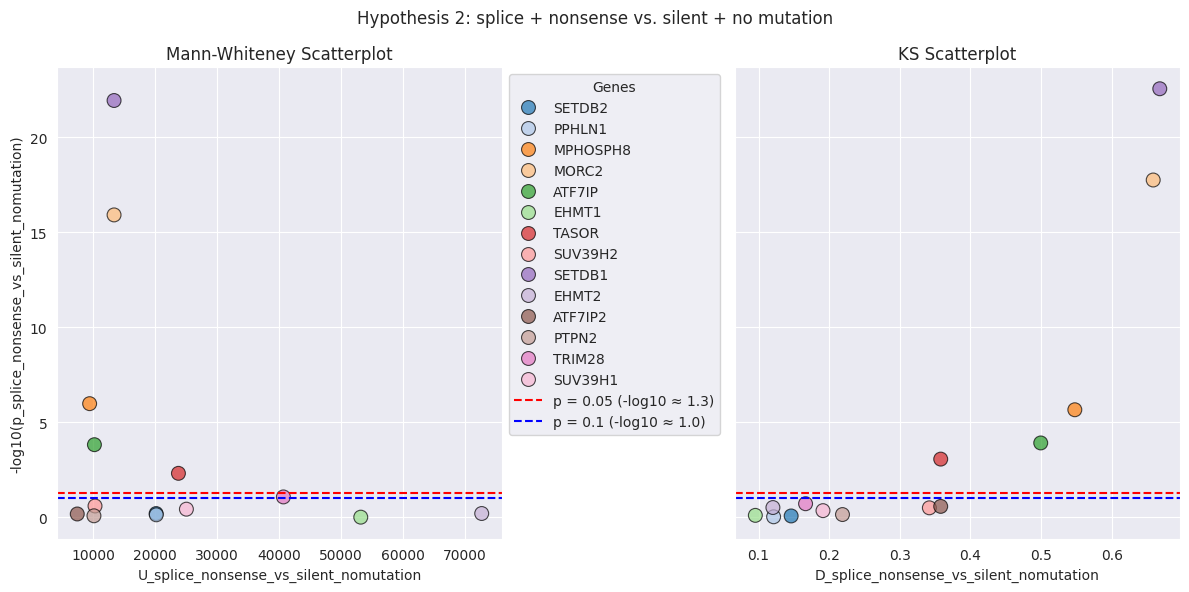

In [ ]:
# @title Visualization for Hypothesis Tests
# @markdown Run this cell to generate scatterplots for the comparison condition
# @markdown specified below. The Mann-Whiteney graph will plot the U value vs. -log10(p)
# @markdown value. The KS graph will do the same, however the x-axis will be the D
# @markdown value instead of U. The scatterplots will be saved to the **plots**
# @markdown folder.
# @markdown ****
# @markdown Which comparison condition would you like to see in the Mann-Whiteney
# @markdown and KS test scatterplots for Hypothesis 2?
comparison_condition ='splice + nonsense vs. silent + no mutation' #@param ["nonsense vs. missense", "nonsense vs. no mutation", "nonsense vs. silent", "splice vs. missense", "splice vs. no mutation", "splice vs. silent", "missense vs. splice + nonsense", "no mutation vs. splice + nonsense", "silent vs. splice + nonsense", "missense vs. silent + no mutation", "nonsense vs. silent + no mutation", "splice vs. silent + no mutation", "no mutation vs. silent", "nonsense vs. splice", "splice + nonsense vs. silent + no mutation"]

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

cases_dictionary = {
    'nonsense vs. missense': '_nonsense_vs_missense',
    'nonsense vs. no mutation': '_nonsense_vs_nomutation',
    'nonsense vs. silent': '_nonsense_vs_silent',
    'splice vs. missense': '_splice_vs_missense',
    'splice vs. no mutation': '_splice_vs_nomutation',
    'splice vs. silent': '_splice_vs_silent',
    'missense vs. splice + nonsense': '_missense_vs_splice_nonsense',
    'no mutation vs. splice + nonsense': '_nomutation_vs_splice_nonsense',
    'silent vs. splice + nonsense': '_silent_vs_splice_nonsense',
    'missense vs. silent + no mutation': '_missense_vs_silent_nomutation',
    'nonsense vs. silent + no mutation': '_nonsense_vs_silent_nomutation',
    'splice vs. silent + no mutation': '_splice_vs_silent_nomutation',
    'no mutation vs. silent': '_nomutation_vs_silent',
    'nonsense vs. splice': '_nonsense_vs_splice',
    'splice + nonsense vs. silent + no mutation': '_splice_nonsense_vs_silent_nomutation'
}
partial_col_header = cases_dictionary[comparison_condition]

# helper function: transform p-values to -log10(p)
def negative_log_transformation(value):
    if pd.notna(value) and value > 0:
        return -np.log10(value)
    return value

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# prepare dataframe for graphing
df_MW_input = pd.read_csv(workdir + "/qc_validation/" + input_screen + "_Mann_Whiteney_test_hypothesis_2.tsv", sep='\t')
df_MW_input.replace(-999, pd.NA, inplace=True)  # replace -999 with NaN
x_column = "U" + partial_col_header
y_column = "p" + partial_col_header
df_MW_input[y_column] = df_MW_input[y_column].apply(negative_log_transformation)

# create scatterplot for Mann-Whiteney test
scatter1 = sns.scatterplot(ax=axes[0], data=df_MW_input, x=x_column, y=y_column, \
                           hue="gene_name", palette='tab20', s=100, alpha=0.7, edgecolor='k')
axes[0].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05 (-log10 ≈ 1.3)')
axes[0].axhline(y=-np.log10(0.1), color='blue', linestyle='--', label='p = 0.1 (-log10 ≈ 1.0)')
axes[0].set_ylabel(f'-log10({y_column})')
axes[0].set_title(f'Mann-Whiteney Scatterplot')

# legend for genes
handles, labels = scatter1.get_legend_handles_labels()
axes[0].legend(handles, labels, title="Genes", bbox_to_anchor=(1.0, 1), loc='upper left')

# prepare dataframe for graphing
df_KS_input = pd.read_csv(workdir + "/qc_validation/" + input_screen + "_KS_test_hypothesis_2.tsv", sep='\t')
df_KS_input.replace(-999, pd.NA, inplace=True)  # replace -999 with NaN
x_column = "D" + partial_col_header
y_column = "p" + partial_col_header
df_KS_input[y_column] = df_KS_input[y_column].apply(negative_log_transformation)

# create scatterplot for KS Test
scatter2 = sns.scatterplot(ax=axes[1], data=df_KS_input, x=x_column, y=y_column, \
                           legend=False, hue="gene_name", palette='tab20', s=100, alpha=0.7, edgecolor='k')
axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05 (-log10 ≈ 1.3)')
axes[1].axhline(y=-np.log10(0.1), color='blue', linestyle='--', label='p = 0.1 (-log10 ≈ 1.0)')
axes[1].set_title(f'KS Scatterplot')

fig.suptitle(f"Hypothesis 2: {comparison_condition}")
plt.tight_layout()

# save plot to plots folder
plt.savefig(workdir + "/plots/" + input_screen + "_hypothesis_2_scatterplot.pdf", dpi=300)

if download == 'Yes':
    files.download(workdir + "/plots/" + input_screen + "_hypothesis_2_scatterplot.pdf")

# Part 2

In [14]:
# @title Target Gene and UniProt ID
# @markdown Enter the name of the Human Gene (ex: SETDB1)
input_gene = 'SETDB1' # @param {type:"string"}

# @markdown Enter the corresponding UniProt ID for given the gene (ex: Q15047)
input_uniid = 'Q15047' # @param {type:"string"}

structureid = f'AF-{input_uniid}-F1-model_v4'

In [15]:
# @title Download GitHub Repo
# @markdown Run this cell to download the BEClust3D GitHub repository into the
# @markdown working directory.

# set current directory to working directory for repository download
os.chdir(workdir)

# check if repo already exists -> remove if it does
if os.path.exists(f'{workdir}/BEClust3D'): shutil.rmtree(f'{workdir}/BEClust3D')
!git clone -b main https://github.com/broadinstitute/BEClust3D.git
sys.path.append(f'{workdir}/BEClust3D/beclust3d')

Cloning into 'BEClust3D'...
remote: Enumerating objects: 544, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 544 (delta 77), reused 68 (delta 64), pack-reused 450 (from 1)
Receiving objects: 100% (544/544), 19.31 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [16]:
# @title Gene Specific Directory
# @markdown Run this cell to create a folder in the working directory named after
# @markdown the input gene given by the user. All relevant files and plots will be
# @markdown saved here for future reference.
if os.path.isdir(f'{workdir}/{input_gene}'):
    print(f'{workdir}/{input_gene} already exists')
else:
    os.makedirs(f'{workdir}/{input_gene}')
    print(f'{workdir}/{input_gene} created!')

/content/drive/My Drive/BE Project/SETDB1 created!


In [24]:
# @title Fasta File
# @markdown Run this cell to dowload the fasta file for the gene selected above.
# @markdown The fasta file will be saved in the working directory.

from af_structural_features import query_uniprot, parse_uniprot

fasta_file = query_uniprot(workdir, input_uniid)
out_fasta = os.path.join(workdir, "fasta.txt")
open(out_fasta, 'a').close()
parse_uniprot(fasta_file, out_fasta)

df_list_file = pd.read_csv(workdir + "/fasta.txt", sep = '\t')
df_InputGene_missense_edits_list = pd.read_csv(f'{workdir}/screendata/{input_gene}_{input_screen}_missense_edits_list.tsv', sep = '\t');
# get gRNA column from missense tsv file
df_list_file['guide'] = df_InputGene_missense_edits_list['gRNA']


arr_all_LFC = []
arr_all_edits = []

for i in range(0, len(df_list_file)):
    human_res_pos = df_list_file.at[i, 'unipos']

    df_this_humanpos_edits = df_InputGene_missense_edits_list.loc[df_InputGene_missense_edits_list['human_pos'] == int(human_res_pos), ]
    df_this_humanpos_edits = df_this_humanpos_edits.reset_index()
    this_humanpos_LFCscore = []

    if len(df_this_humanpos_edits) > 1:
        #edit
        this_humanpos_edits_list = df_this_humanpos_edits['edit'].tolist()
        this_humanpos_edits_str = ';'.join(list(this_humanpos_edits_list))
        #score
        this_humanpos_LFCscore = list(df_this_humanpos_edits['LFC'])

    elif len(df_this_humanpos_edits) == 1:
        this_humanpos_edits_str = df_this_humanpos_edits.at[0,'edit']
        this_humanpos_LFCscore.append(df_this_humanpos_edits['LFC'][0])
    else:
        this_humanpos_edits_str = '-'
        this_humanpos_LFCscore = '-'

    arr_all_LFC.append(this_humanpos_LFCscore)
    arr_all_edits.append(this_humanpos_edits_str)

df_list_file['all_missense_edits'] = arr_all_edits
df_list_file['all_missense_LFC'] = arr_all_LFC

df_list_file.head(10)

,unipos,unires,guide,all_missense_edits,all_missense_LFC
0,1,M,AACACACGCCAATTCTATGA,-,-
1,2,S,AACACACGCCAATTCTATGA,-,-
2,3,S,AACAGAACATCTCCAGGAAG,S3F,[-0.384]
3,4,L,AACATCCTCAGCCTCTGCAC,L4F,[-0.384]
4,5,P,AACATGGCCTCTGTGGACAA,P5F,[-0.253]
5,6,G,AACCGGTTTGTGCACATGTT,-,-
6,7,C,AAGACGTCCTCTGCATTCAA,-,-
7,8,I,AAGACGTCCTCTGCATTCAA,-,-
8,9,G,AAGACTAATGAAGGTGGGGA,G9N;G9N,"[0.687, 0.685]"
9,10,L,AAGAGCACGTCCTTTCGACC,-,-


In [25]:
# @title List File
# @markdown Run this cell to create the list file.
# @markdown The list file will be saved in the gene specific folder.
# @markdown
# @markdown Which method would you like to use for calculating a single LFC score per residue?
res_calculation ='Mean' #@param ["Mean", "Min", "Max"]

# calculate final column based on user's choice of metric
if res_calculation == 'Mean':
    df_list_file['mean_missense_LFC'] = df_list_file['all_missense_LFC'].apply(lambda x: np.mean(x) if x != '-' else '-')
if res_calculation == 'Min':
    df_list_file['min_missense_LFC'] = df_list_file['all_missense_LFC'].apply(lambda x: np.min(x) if x != '-' else '-')
if res_calculation == 'Max':
    df_list_file['max_missense_LFC'] = df_list_file['all_missense_LFC'].apply(lambda x: np.max(x) if x != '-' else '-')

# save results
df_list_file.to_csv(f'{workdir}/{input_gene}/list_file.tsv', sep = '\t', index=False)
df_list_file.head(10)


,unipos,unires,guide,all_missense_edits,all_missense_LFC,mean_missense_LFC
0,1,M,AACACACGCCAATTCTATGA,-,-,-
1,2,S,AACACACGCCAATTCTATGA,-,-,-
2,3,S,AACAGAACATCTCCAGGAAG,S3F,[-0.384],-0.384
3,4,L,AACATCCTCAGCCTCTGCAC,L4F,[-0.384],-0.384
4,5,P,AACATGGCCTCTGTGGACAA,P5F,[-0.253],-0.253
5,6,G,AACCGGTTTGTGCACATGTT,-,-,-
6,7,C,AAGACGTCCTCTGCATTCAA,-,-,-
7,8,I,AAGACGTCCTCTGCATTCAA,-,-,-
8,9,G,AAGACTAATGAAGGTGGGGA,G9N;G9N,"[0.687, 0.685]",0.686
9,10,L,AAGAGCACGTCCTTTCGACC,-,-,-


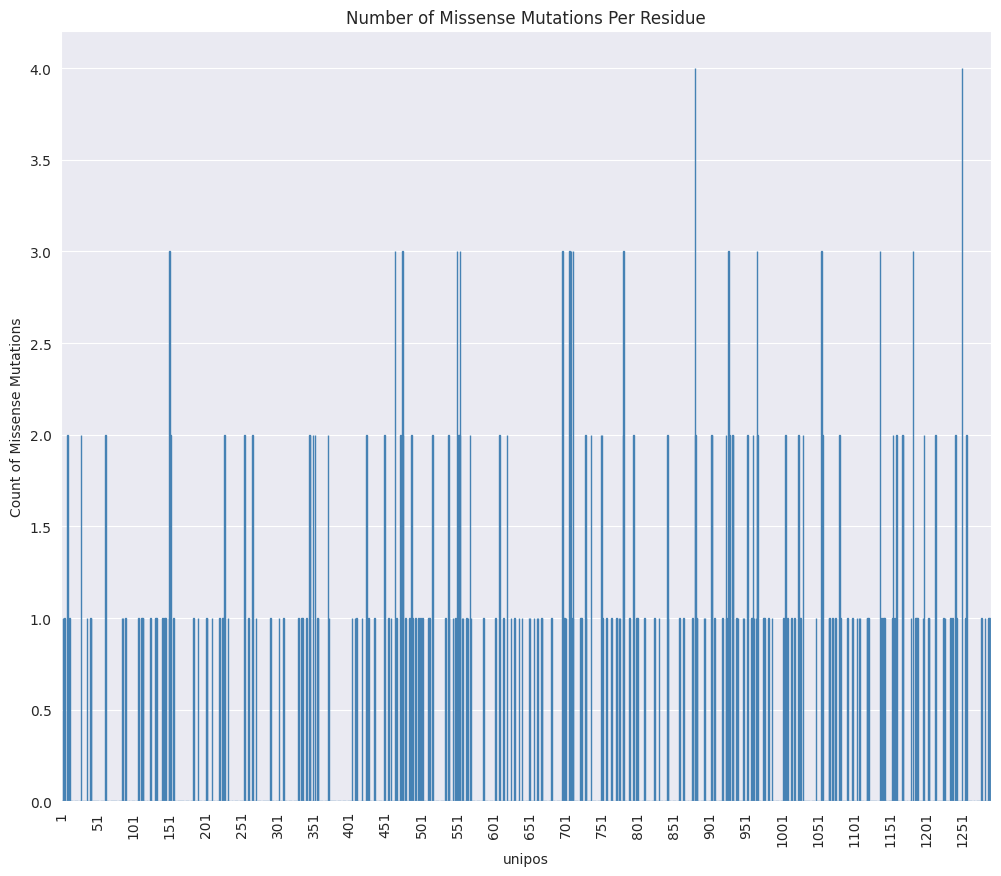

In [21]:
# @title Missense Mutations Per Residue Barplot
# @markdown Run this cell to create a barplot that displays the number of missense
# @markdown mutations per amino acid position. The figure will be saved in the
# @markdown gene specific folder.

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

df_plot = pd.DataFrame()
df_plot['unipos'] = df_list_file['unipos']
df_plot['LFC_counts'] = df_list_file['all_missense_LFC'].apply(lambda x: len(x) if x != '-' else 0)

import matplotlib.ticker as ticker
plt.figure(figsize=(12, 10))
ax = sns.barplot(data=df_plot, x='unipos', y='LFC_counts', color='steelblue', edgecolor='steelblue')
ax.set_ylabel("Count of Missense Mutations")
ax.set_title("Number of Missense Mutations Per Residue")
plt.xticks(np.arange(0,len(df_list_file), 50), rotation = 90);

plt.savefig(f'{workdir}/{input_gene}/num_missense_per_residue.pdf', dpi=300)
if download == 'Yes':
    files.download(f'{workdir}/{input_gene}/num_missense_per_residue.pdf')

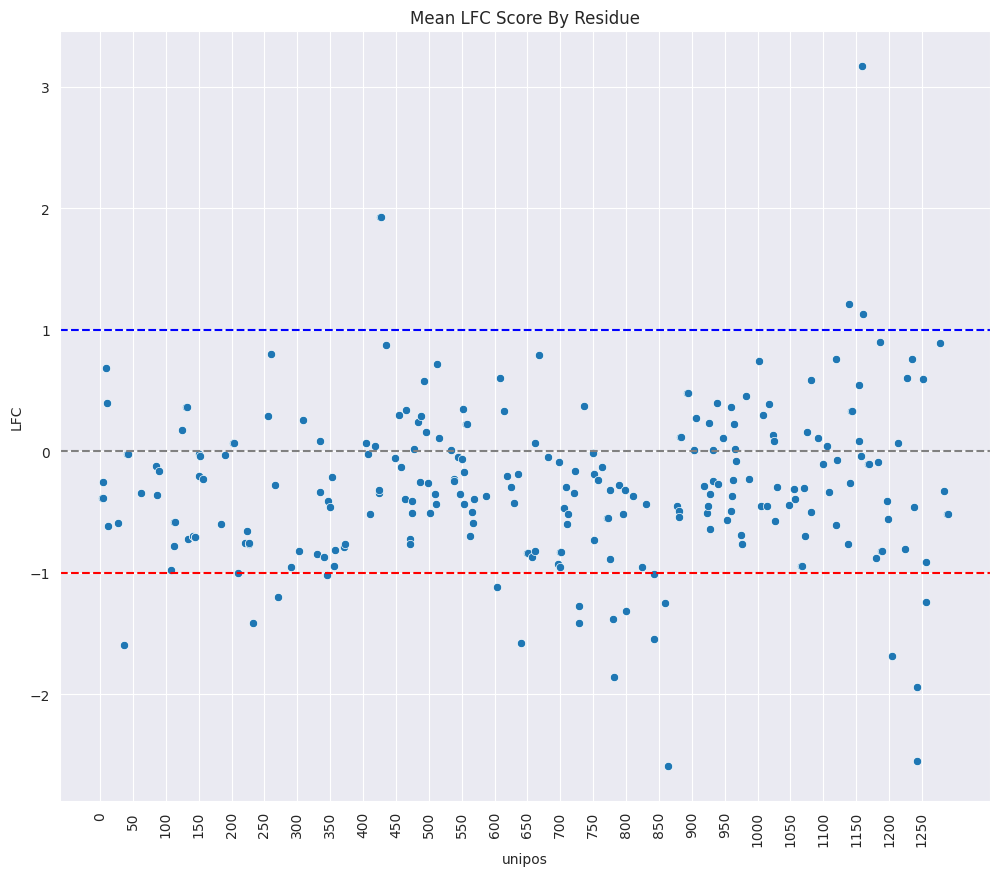

In [22]:
# @title LFC Score By Residue Scatterplot
# @markdown Run this cell to create a scatterplot that shows the LFC score at
# @markdown each amino acid position. The figure will be saved in the gene specific
# @markdown folder.

# @markdown Would you like to download the figure?
download ='No' #@param ["Yes", "No"]

df_plot = pd.DataFrame()
if res_calculation == 'Mean':
    df_plot['unipos'] = df_list_file.loc[df_list_file['mean_missense_LFC'] != '-', 'unipos']
    df_plot['LFC'] = df_list_file['mean_missense_LFC'].apply(lambda x: x if x != '-' else 0)
if res_calculation == 'Min':
    df_plot['unipos'] = df_list_file.loc[df_list_file['min_missense_LFC'] != '-', 'unipos']
    df_plot['LFC'] = df_list_file['min_missense_LFC'].apply(lambda x: x if x != '-' else 0)
if res_calculation == 'Max':
    df_plot['unipos'] = df_list_file.loc[df_list_file['max_missense_LFC'] != '-', 'unipos']
    df_plot['LFC'] = df_list_file['max_missense_LFC'].apply(lambda x: x if x != '-' else 0)

plt.figure(figsize=(12, 10))
g = sns.scatterplot(data=df_plot, x='unipos', y='LFC')
g.axhline(-1.0, c="red", linestyle="--")
g.axhline(1.0, c="blue", linestyle="--")
g.axhline(0.0, c="gray", linestyle="--")
g.set_title(f'{res_calculation} LFC Score By Residue')
plt.xticks(np.arange(0,len(df_list_file), 50), rotation = 90);

plt.savefig(f'{workdir}/{input_gene}/lfc_score_by_residue.pdf', dpi=300)
if download == 'Yes':
    files.download(f'{workdir}/{input_gene}/lfc_score_by_residue.pdf')


In [23]:
# @title One-tail Analysis
# @markdown Compute z_LFC and p_LFC, taking into account the sign of the LFC value.
# @markdown A separate mean and standard deviation will be calculated for positive
# @markdown and negative LFC values.

df_InputGene_nomutation = pd.read_csv(f'{workdir}/screendata/{input_gene}_{input_screen}_no_edits_list.tsv', sep = '\t')
df_InputGene_protein_edits = pd.read_csv(f'{workdir}/{input_gene}/list_file.tsv', sep = '\t')

list_z_LFC = []
list_p_LFC = []
list_plab_LFC = []

# negative
df_InputGene_nomutation_neg = df_InputGene_nomutation.loc[df_InputGene_nomutation['LFC'] < 0.0, ]
mu_neg = df_InputGene_nomutation_neg['LFC'].mean()
sigma_neg = df_InputGene_nomutation_neg['LFC'].std()

# positive
df_InputGene_nomutation_pos = df_InputGene_nomutation.loc[df_InputGene_nomutation['LFC'] > 0.0, ]
mu_pos = df_InputGene_nomutation_pos['LFC'].mean()
sigma_pos = df_InputGene_nomutation_pos['LFC'].std()

for i in range(0, len(df_InputGene_protein_edits)):
    LFC_raw = df_InputGene_protein_edits.at[i, 'mean_missense_LFC']

    if LFC_raw == '-':
        LFC = 0.0
        z_LFC = 0.0
        p_LFC = 1.0
        plab_LFC = 'p=1.0'
    else:
        LFC = float(df_InputGene_protein_edits.at[i, 'mean_missense_LFC'])

        if (LFC < 0.0):

            z_LFC = statistics.NormalDist(mu=mu_neg, sigma=sigma_neg).zscore(LFC)
            p_LFC = stats.norm.sf(abs(z_LFC))

            if z_LFC < -3.29:
                plab_LFC = '-p=0.001'
            elif (z_LFC >= -3.29) and (z_LFC < -2.58):
                plab_LFC = '-p=0.01'
            elif (z_LFC >= -2.58) and (z_LFC < -1.96):
                plab_LFC = '-p=0.05'
            elif (z_LFC >= -1.96) and (z_LFC < -1.65):
                plab_LFC = '-p=0.1'
            elif (z_LFC >= -1.65) and (z_LFC < -1.0):
                plab_LFC = '-p=0.3'
            else:
                plab_LFC = '-p=1.0'
        elif (LFC > 0.0):

            z_LFC = statistics.NormalDist(mu=mu_pos, sigma=sigma_pos).zscore(LFC)
            p_LFC = stats.norm.sf(abs(z_LFC))

            if z_LFC > 3.29:
                plab_LFC = '+p=0.001'
            elif (z_LFC <= 3.29) and (z_LFC > 2.58):
                plab_LFC = '+p=0.01'
            elif (z_LFC <= 2.58) and (z_LFC > 1.96):
                plab_LFC = '+p=0.05'
            elif (z_LFC <= 1.95) and (z_LFC > 1.65):
                plab_LFC = '+p=0.1'
            elif (z_LFC <= 1.65) and (z_LFC > 1.0):
                plab_LFC = '+p=0.3'
            else:
                plab_LFC = '+p=1.0'
        else:
            plab_LFC = 'p=1.0'


    list_z_LFC.append(z_LFC)
    list_p_LFC.append(p_LFC)
    list_plab_LFC.append(plab_LFC)

df_InputGene_protein_edits['z_LFC'] = list_z_LFC
df_InputGene_protein_edits['p_LFC'] = list_p_LFC
df_InputGene_protein_edits['plab_LFC'] = list_plab_LFC

df_InputGene_protein_edits.head(10)

,unipos,unires,guides,all_missense_edits,all_missense_LFC,mean_missense_LFC,z_LFC,p_LFC,plab_LFC
0,1,M,AACACACGCCAATTCTATGA,-,-,-,0.000000,1.000000,p=1.0
1,2,S,AACACACGCCAATTCTATGA,-,-,-,0.000000,1.000000,p=1.0
2,3,S,AACAGAACATCTCCAGGAAG,S3F,[-0.384],-0.384,0.524815,0.299856,-p=1.0
3,4,L,AACATCCTCAGCCTCTGCAC,L4F,[-0.384],-0.384,0.524815,0.299856,-p=1.0
4,5,P,AACATGGCCTCTGTGGACAA,P5F,[-0.253],-0.253,0.795368,0.213200,-p=1.0
5,6,G,AACCGGTTTGTGCACATGTT,-,-,-,0.000000,1.000000,p=1.0
6,7,C,AAGACGTCCTCTGCATTCAA,-,-,-,0.000000,1.000000,p=1.0
7,8,I,AAGACGTCCTCTGCATTCAA,-,-,-,0.000000,1.000000,p=1.0
8,9,G,AAGACTAATGAAGGTGGGGA,G9N;G9N,"[0.687, 0.685]",0.686,0.111438,0.455634,+p=1.0
9,10,L,AAGAGCACGTCCTTTCGACC,-,-,-,0.000000,1.000000,p=1.0


Text(0.5, 1.0, 'Negative LFC Counts')

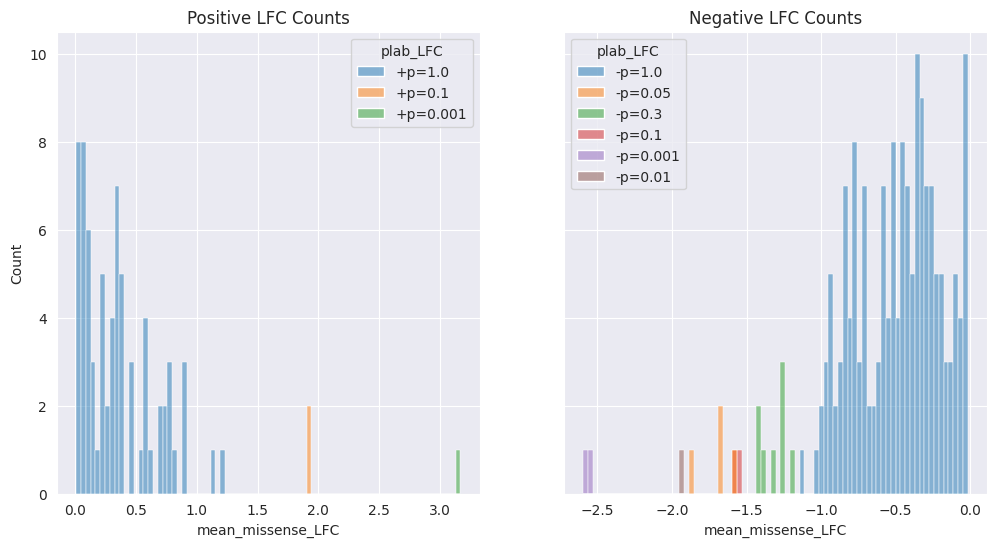

In [28]:
# @title Mean Missense LFC Counts

df_LFC_LFC3D_dis_screen_nodash = df_InputGene_protein_edits.loc[df_InputGene_protein_edits['mean_missense_LFC'] != '-', ]
df_LFC_LFC3D_dis_screen_nodash = df_LFC_LFC3D_dis_screen_nodash.reset_index(drop=True)
df_LFC_LFC3D_dis_screen_nodash['mean_missense_LFC'] = df_LFC_LFC3D_dis_screen_nodash['mean_missense_LFC'].astype(float)

# create dataframe for positive LFC values
df_LFC_LFC3D_pos = df_LFC_LFC3D_dis_screen_nodash.loc[df_LFC_LFC3D_dis_screen_nodash['mean_missense_LFC'] > 0.0, ]
df_LFC_LFC3D_pos = df_LFC_LFC3D_pos.reset_index(drop=True)
min_LFC3D_pos = df_LFC_LFC3D_pos['mean_missense_LFC'].min()
max_LFC3D_pos = df_LFC_LFC3D_pos['mean_missense_LFC'].max()

# create dataframe for negative LFC values
df_LFC_LFC3D_neg = df_LFC_LFC3D_dis_screen_nodash.loc[df_LFC_LFC3D_dis_screen_nodash['mean_missense_LFC'] < 0.0, ]
df_LFC_LFC3D_neg = df_LFC_LFC3D_neg.reset_index(drop=True)
min_LFC3D_neg = df_LFC_LFC3D_neg['mean_missense_LFC'].min()
max_LFC3D_neg = df_LFC_LFC3D_neg['mean_missense_LFC'].max()

# plot histograms
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
plot1 = sns.histplot(ax=axs[0], data=df_LFC_LFC3D_pos, x='mean_missense_LFC', hue='plab_LFC', bins=80, palette='tab10');
plot2 = sns.histplot(ax=axs[1], data=df_LFC_LFC3D_neg, x='mean_missense_LFC', hue='plab_LFC', bins=80, palette='tab10');

# give corresponding titles
plot1.set_title(f'Positive LFC Counts')
plot2.set_title(f'Negative LFC Counts')

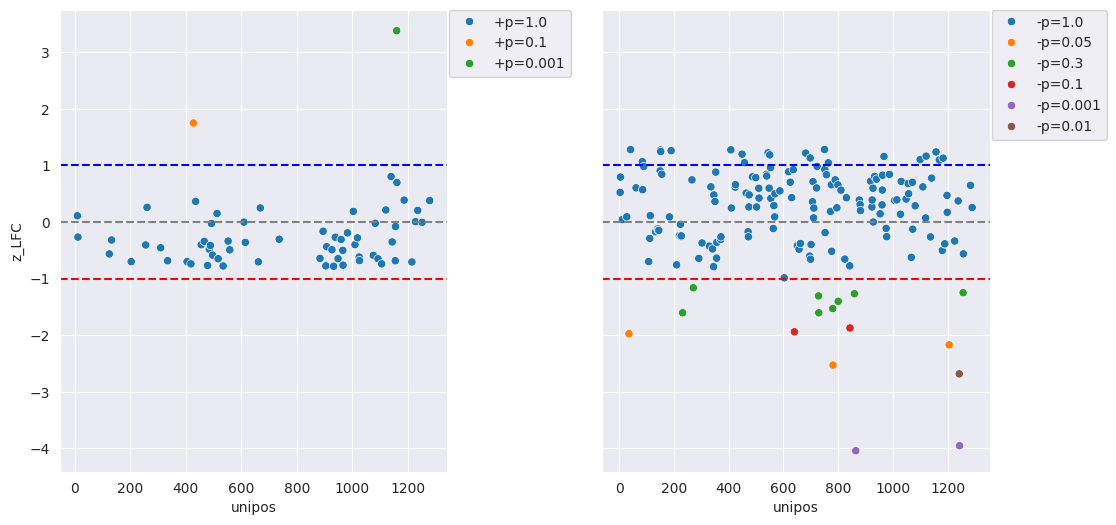

In [37]:
# @title z_LFC Scatterplots

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
plot1 = sns.scatterplot(ax=axs[0], data=df_LFC_LFC3D_pos, x="unipos", y='z_LFC', hue='plab_LFC', palette='tab10')
plot1.axhline(-1.0, c="red", linestyle="--")
plot1.axhline(1.0, c="blue", linestyle="--")
plot1.axhline(0.0, c="gray", linestyle="--")
plot1.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0);

plot2 = sns.scatterplot(ax=axs[1], data=df_LFC_LFC3D_neg, x="unipos", y='z_LFC', hue='plab_LFC', palette='tab10')
plot2.axhline(-1.0, c="red", linestyle="--")
plot2.axhline(1.0, c="blue", linestyle="--")
plot2.axhline(0.0, c="gray", linestyle="--")
plot2.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0);
plt.subplots_adjust(wspace=0.4)

In [26]:
from af_structural_features import af_structural_features

af_structural_features(workdir=workdir, input_gene=input_gene, input_uniprot=input_uniid, structureid=structureid)

MKDSSP API Job ID is 4e0173bc-21ce-48b3-b875-ef9d36aa5786
Fetching job result ...
MKDSSP query complete.


,unipos,unires,x_coord,y_coord,z_coord,bfactor_pLDDT,Naa_count,Naa,Naa_pos,SS9,...,ACC,RSA,exposure,PHI,normPHI,PSI,normPSI,dBurial,normSumdBurial,pLDDT_dis
0,1,M,40.740,39.109,-6.115,36.75,1,S,2,L,...,233,1.04,exposed,360.0,2.00,157.3,0.87,0.00,0.000,very low
1,2,S,37.812,38.895,-3.704,32.83,2,M;S,1;3,L,...,103,0.66,medexposed,35.4,0.20,133.7,0.74,0.38,0.076,very low
2,3,S,35.498,37.485,-2.174,32.79,2,S;L,2;4,L,...,99,0.64,medexposed,179.7,1.00,177.6,0.99,0.40,0.120,very low
3,4,L,32.875,36.126,0.319,42.90,2,S;P,3;5,L,...,165,0.82,exposed,94.0,0.52,156.7,0.87,0.22,0.079,very low
4,5,P,31.112,32.952,1.735,39.74,2,L;G,4;6,L,...,115,0.72,medexposed,-102.6,-0.57,165.8,0.92,0.32,0.090,very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,1287,R,3.341,-6.712,-10.508,85.91,3,C;G;R,1286;1288;1289,L,...,104,0.42,medburied,-63.4,-0.35,-9.9,-0.06,0.62,0.552,confident
1287,1288,G,5.709,-4.495,-12.671,86.20,6,E;D;C;C;R;R,1146;1147;1279;1286;1287;1289,S,...,9,0.09,buried,71.4,0.40,-39.9,-0.22,0.95,0.798,confident
1288,1289,R,2.800,-4.128,-15.192,86.79,7,L;L;C;R;G;L;L,1277;1278;1279;1287;1288;1290;1291,B,...,69,0.28,medburied,-126.4,-0.70,162.4,0.90,0.76,0.616,confident
1289,1290,L,-0.974,-3.633,-15.073,80.70,7,Y;V;L;L;C;R;L,1267;1269;1277;1278;1279;1289;1291,L,...,11,0.05,buried,-104.3,-0.58,-44.6,-0.25,0.99,0.733,confident


In [ ]:
# @title LFC to LFC3D

df_struc_consvr_3daggr = pd.DataFrame()
df_struc_consvr_3daggr['unipos'] = df_struc_consvr['unipos']
df_struc_consvr_3daggr['unires'] = df_struc_consvr['unires']

df_struc_consvr_edits = pd.read_csv(workdir + input_gene + "/randomized_screendata/" + input_gene + "_" + input_screen + "_struc_consrv_missenseedits_randomized.tsv", sep = "\t")

taa_wise_sum_LFC = []
taa_wise_norm_LFC = []

for aa in range(0, len(df_struc_consvr_edits)):
    taa_res = df_struc_consvr_edits.at[aa,'unires'] # target amino acid
    taa_naa_count = df_struc_consvr_edits.at[aa,'Naa_count'] ## neighboring residue count (not including the target)

    naa_str = df_struc_consvr_edits.at[aa,'Naa'] # neighboring amino acids
    naa_pos_str = df_struc_consvr_edits.at[aa,'Naa_pos'] #neighboring residue positions

    taa_LFC = df_struc_consvr_edits.at[aa,'mean_missense_LFC'] # target LFC

    naa_list = naa_str.split(';')
    naa_pos_list = naa_pos_str.split(';')

    taa_naa_wBE_LFC = 0; #residues that are conserved and with a BE edit value
    sum_taa_naa_LFC = 0.0
    taa_pos_conservation = df_struc_consvr_edits.at[aa,'conservation']

    #if taa_pos_conservation == "conserved":
    if taa_LFC != '-':
        taa_naa_wBE_LFC = 1;
        sum_taa_naa_LFC = float(taa_LFC)

    for j in range(0, len(naa_list)):
        naa_pos = int(naa_pos_list[j])
        naa_pos_conservation = df_struc_consvr_edits.at[naa_pos-1,'conservation']

        #if naa_pos_conservation == "conserved":
        naa_LFC = df_struc_consvr_edits.at[naa_pos-1,'mean_missense_LFC']
        if naa_LFC != '-':
            sum_taa_naa_LFC = sum_taa_naa_LFC + float(naa_LFC)
            taa_naa_wBE_LFC = taa_naa_wBE_LFC + 1


    if taa_naa_wBE_LFC == 0:
        taa_wise_sum_LFC.append('-')
        taa_wise_norm_LFC.append('-')
    else:
        taa_wise_sum_LFC.append(str(round(sum_taa_naa_LFC, 3)))
        taa_wise_norm_LFC.append(str(round(sum_taa_naa_LFC/taa_naa_wBE_LFC, 3)))

header_LFC = input_screen + "_LFC";
header_LFC3D = input_screen + "_LFC3D";
df_struc_consvr_3daggr[header_LFC] = df_struc_consvr_edits['mean_missense_LFC']
df_struc_consvr_3daggr[header_LFC3D] = taa_wise_norm_LFC


for r in range(0,nRandom):
    col_head = 'mean_missense_LFCr' + str(r+1)

    taa_wise_sum_LFC = []
    taa_wise_norm_LFC = []

    for aa in range(0, len(df_struc_consvr_edits)):
        taa_res = df_struc_consvr_edits.at[aa,'unires'] # target amino acid
        taa_naa_count = df_struc_consvr_edits.at[aa,'Naa_count'] ## neighboring residue count (not including the target)

        naa_str = df_struc_consvr_edits.at[aa,'Naa'] # neighboring amino acids
        naa_pos_str = df_struc_consvr_edits.at[aa,'Naa_pos'] #neighboring residue positions


        taa_LFC = df_struc_consvr_edits.at[aa,col_head] # target LFC

        naa_list = naa_str.split(';')
        naa_pos_list = naa_pos_str.split(';')

        taa_naa_wBE_LFC = 0; #residues that are conserved and with a BE edit value
        sum_taa_naa_LFC = 0.0
        taa_pos_conservation = df_struc_consvr_edits.at[aa,'conservation']

        #if taa_pos_conservation == "conserved":
        if taa_LFC != '-':
            taa_naa_wBE_LFC = 1;
            sum_taa_naa_LFC = float(taa_LFC)

        for j in range(0, len(naa_list)):
            naa_pos = int(naa_pos_list[j])
            naa_pos_conservation = df_struc_consvr_edits.at[naa_pos-1,'conservation']

            #if naa_pos_conservation == "conserved":
            naa_LFC = df_struc_consvr_edits.at[naa_pos-1, col_head]
            if naa_LFC != '-':
                sum_taa_naa_LFC = sum_taa_naa_LFC + float(naa_LFC)
                taa_naa_wBE_LFC = taa_naa_wBE_LFC + 1

        if taa_naa_wBE_LFC == 0:
            taa_wise_sum_LFC.append('-')
            taa_wise_norm_LFC.append('-')
        else:
            taa_wise_sum_LFC.append(str(round(sum_taa_naa_LFC, 3)))
            taa_wise_norm_LFC.append(str(round(sum_taa_naa_LFC/taa_naa_wBE_LFC, 3)))


    header_LFC = input_screen + "_LFCr" + str(r+1);
    header_LFC3D = input_screen + "_LFC3Dr" + str(r+1);
    df_struc_consvr_3daggr[header_LFC] = df_struc_consvr_edits[col_head]
    df_struc_consvr_3daggr[header_LFC3D] = taa_wise_norm_LFC
